In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
from scipy.optimize import curve_fit as cv
import numpy as np
import pickle

# Labs 7 and 8

In [2]:
# open the file of interest, and use pickle loading
infile = open ("Sample_pt_250_500/qcd_100000_pt_250_500.pkl",'rb')
qcd_data = pickle.load(infile)
higgs_data = pickle.load(open ("Sample_pt_250_500/higgs_100000_pt_250_500.pkl",'rb'))

# list all keys of the files
print(qcd_data.keys())

Index(['pt', 'eta', 'phi', 'mass', 'ee2', 'ee3', 'd2', 'angularity', 't1',
       't2', 't3', 't21', 't32', 'KtDeltaR'],
      dtype='object')


In [3]:

def histograms(var, name, units):
    plt.rcParams["figure.figsize"] = (15,10)  
    fig, ax = plt.subplots(1, 2)

    ax[0].hist(qcd_data.get(var), color = 'red', alpha=0.5, label = 'QCD data', bins = 27)
    ax[0].hist(higgs_data.get(var), alpha=0.5, label='Higgs data', bins = 27)
    ax[1].hist(qcd_data.get(var), color = 'red', alpha=0.5, label = 'QCD data', bins = 27)
    ax[1].hist(higgs_data.get(var), alpha=0.5, label='Higgs data', bins = 27)

    ax[0].set_title('Histograms of Higgs ' + name + ' with QCD '+ name)
    ax[0].set_ylabel('Counts')
    ax[0].set_xlabel(r'' + name + ' (' + units + ')')
    ax[0].legend()

    ax[1].set_title('Histograms of Higgs ' + name + ' with QCD '+ name)
    ax[1].set_ylabel('log[Counts]')
    ax[1].set_xlabel(r'' + name + ' (' + units + ')')
    ax[1].legend()
    ax[1].set_yscale('log')
    
    return ax

To begin this lab, I will make a stacked histogram plot for the mass 

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f26263994e0>,
      dtype=object)

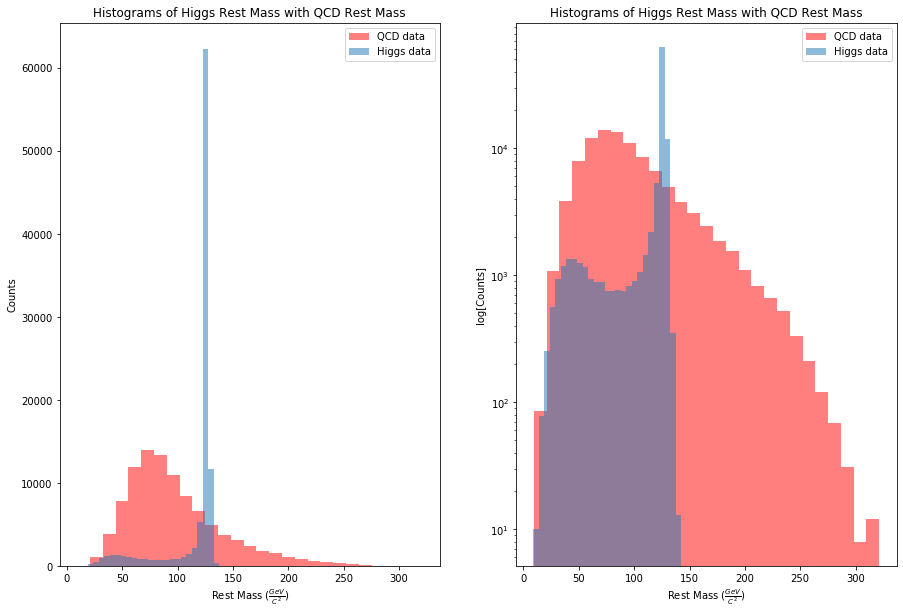

In [4]:
histograms('mass', 'Rest Mass', r'$\frac{GeV}{C^2}$')

In [5]:
background_count = 20000 # given in dataset
total_count = background_count + 100 # given in dataset

prob = stats.poisson.sf(total_count, mu=background_count)

print('Significance: \t',prob)

sn_ratio = (100) / (20000**0.5)

print('Ratio:         \t', sn_ratio)

Significance: 	 0.23847212190687442
Ratio:         	 0.7071067811865475


The ratio of $\frac{N_{Higgs}}{\sqrt{N_{QCD}}}$ represents the ratio of the number of Higgs particles in our data set vs the standard deviation of the QCD background.  If this number is smaller than one, then the number of Higgs is inside of the standard deviation of the background, which is the case here.

For the QCD backgound, I only got a significance of 23.8%, which means that about a quarter of the time, I'd expect a number of events equal to the number I detected or higher.

To approach the problem of doing cuts to increase my significance, I must first weight the two distributions given that their are 100 Higgs counts and 20000 QCD counts in our data set.

In [6]:
weight_higgs = higgs_data.get('mass').size / 100
weight_qcd = qcd_data.get('mass').size / 20000
print('Weight Higgs:\t',weight_higgs)
print('Weight QCD:\t',weight_qcd)

Weight Higgs:	 1000.0
Weight QCD:	 5.0


What this means is that 1000 Higgs counts in my data set corrospond to one Higgs detection and every 5 QCD counts in my data set corrospond to one QCD detection.  I can know cut the background to maximize my significance.

In [118]:
cut_level = 0
minimum_cut_level = 110
minimum_cut_sig = 1
significance = 1
five_sigma = stats.norm.sf(5)

while significance > five_sigma:
    cut_level += 0.1
    higgs_count = np.count_nonzero(higgs_data.get('mass') > cut_level) / weight_higgs
    qcd_count = np.count_nonzero(qcd_data.get('mass') > cut_level) / weight_qcd 
    significance = stats.poisson.sf(higgs_count + qcd_count, mu=qcd_count)
    
    if significance < minimum_cut_sig and higgs_count > 0.0 and qcd_count > 0.0:
        minimum_cut_sig = significance
        minimum_cut_level = cut_level

        
max_cut_level = 140
max_cut_sig = 1
cut_level = int(qcd_data.get('mass').max())
significance = 1
while significance > five_sigma:
    cut_level -= 0.1
    higgs_count = np.count_nonzero((higgs_data.get('mass') > minimum_cut_level) & (higgs_data.get('mass') < cut_level)) / weight_higgs
    qcd_count = np.count_nonzero((qcd_data.get('mass') > minimum_cut_level) & (qcd_data.get('mass') < cut_level)) / weight_qcd
    significance = stats.poisson.sf(higgs_count + qcd_count, mu=qcd_count)
    
    if significance < max_cut_sig and higgs_count > 0.0 and qcd_count > 0.0:
        max_cut_level = cut_level
        max_cut_sig = significance
  

higgs_count = np.count_nonzero((higgs_data.get('mass') > minimum_cut_level) & (higgs_data.get('mass') < max_cut_level)) / weight_higgs
qcd_count = np.count_nonzero((qcd_data.get('mass') > minimum_cut_level) & (qcd_data.get('mass') < max_cut_level)) / weight_qcd
significance = stats.poisson.sf(higgs_count + qcd_count, mu=qcd_count)
print('Min Cut Level:\t', np.round(minimum_cut_level, decimals=2))
print('Max Cut Level:\t', np.round(max_cut_level, decimals=2))
print('Significance:\t', significance)
print('Higgs Counts:\t',int(higgs_count))
print('QCD Counts:\t', int(qcd_count))
mass_min = minimum_cut_level
mass_max = max_cut_level

Min Cut Level:	 119.3
Max Cut Level:	 129.0
Significance:	 0.009418115498960086
Higgs Counts:	 73
QCD Counts:	 975


Note, it is actually impossible to get a $5\sigma$ significance on the mass because you start cutting out too much signal.

(119.3, 129)

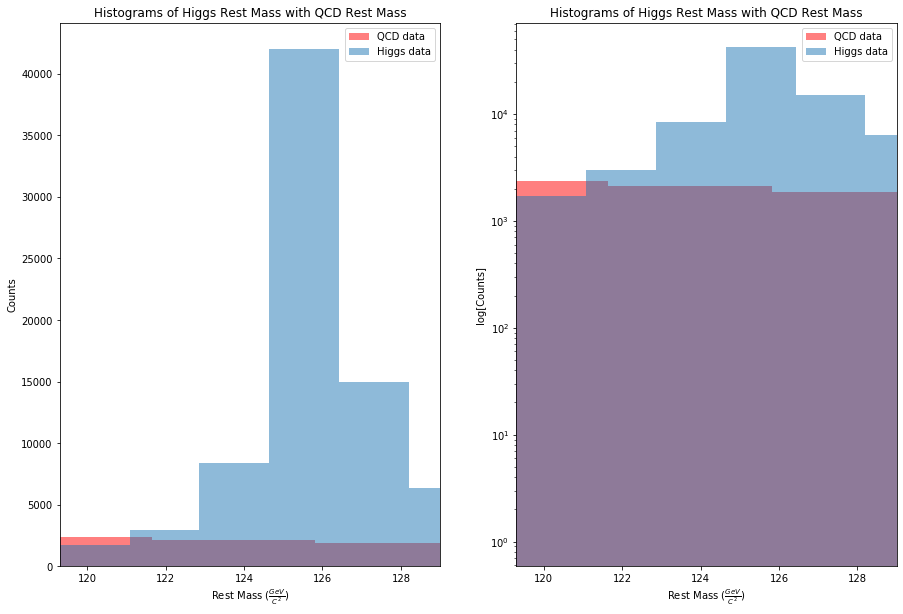

In [8]:
plt.rcParams["figure.figsize"] = (15,10)  
fig, ax = plt.subplots(1, 2)

ax[0].hist(qcd_data.get('mass'), color = 'red', alpha=0.5, label = 'QCD data', bins = 75)
ax[0].hist(higgs_data.get('mass'), alpha=0.5, label='Higgs data', bins = 75)
ax[1].hist(qcd_data.get('mass'), color = 'red', alpha=0.5, label = 'QCD data', bins = 75)
ax[1].hist(higgs_data.get('mass'), alpha=0.5, label='Higgs data', bins = 75)

ax[0].set_title('Histograms of Higgs ' + 'Rest Mass' + ' with QCD ' + 'Rest Mass')
ax[0].set_ylabel('Counts')
ax[0].set_xlabel(r'Rest Mass ($\frac{GeV}{C^2}$)')
ax[0].legend()

ax[1].set_title('Histograms of Higgs ' + 'Rest Mass' + ' with QCD ' + 'Rest Mass')
ax[1].set_ylabel('log[Counts]')
ax[1].set_xlabel(r'Rest Mass ($\frac{GeV}{C^2}$)')
ax[1].legend()
ax[1].set_yscale('log')
ax[0].set_xlim([119.3,129])
ax[1].set_xlim([119.3,129])

In [52]:
def histograms_2(x_1, x_2, name, bins):
    plt.rcParams["figure.figsize"] = (15,10)  
    fig, ax = plt.subplots(1, 2)

    ax[0].hist(x_1, color = 'red', alpha=0.5, label = 'QCD data', bins = bins, density = True)
    ax[0].hist(x_2, alpha=0.5, label='Higgs data', bins = bins, density = True)
    ax[1].hist(x_1, color = 'red', alpha=0.5, label = 'QCD data', bins = bins, density = True)
    ax[1].hist(x_2, alpha=0.5, label='Higgs data', bins = bins, density = True)

    ax[0].set_title('Histograms of Higgs ' + name + ' with QCD '+ name)
    ax[0].set_ylabel('Frequency')
    ax[0].set_xlabel(name)
    ax[0].legend()

    ax[1].set_title('Histograms of Higgs ' + name + ' with QCD '+ name)
    ax[1].set_ylabel('log[Frequency]')
    ax[1].set_xlabel(name)
    ax[1].legend()
    ax[1].set_yscale('log')
    
    return ax

In [17]:
# this block of code iterates through all of the mass data and compiles the other variables where the mass is eithin the predefined cut

higgs_cuts = {'pt' : [], 'eta' : [], 'phi' : [], 'mass' : [], 'ee2' : [], 'ee3' : [], 'd2' : [], 'angularity' : [], 't1' : [],
       't2' : [], 't3' : [], 't21' : [], 't32' : [], 'KtDeltaR' : []}
qcd_cuts = {'pt' : [], 'eta' : [], 'phi' : [], 'mass' : [], 'ee2' : [], 'ee3' : [], 'd2' : [], 'angularity' : [], 't1' : [],
       't2' : [], 't3' : [], 't21' : [], 't32' : [], 'KtDeltaR' : []}

for index in range(higgs_data.get('mass').size):
    if higgs_data.get('mass')[index] > minimum_cut_level and higgs_data.get('mass')[index] < max_cut_level:
        for var in higgs_data.keys():
            higgs_cuts.get(var).append(higgs_data.get(var)[index])
         
    if qcd_data.get('mass')[index] > minimum_cut_level and qcd_data.get('mass')[index] < max_cut_level:
        for var in higgs_data.keys():
            qcd_cuts[var].append(qcd_data.get(var)[index])

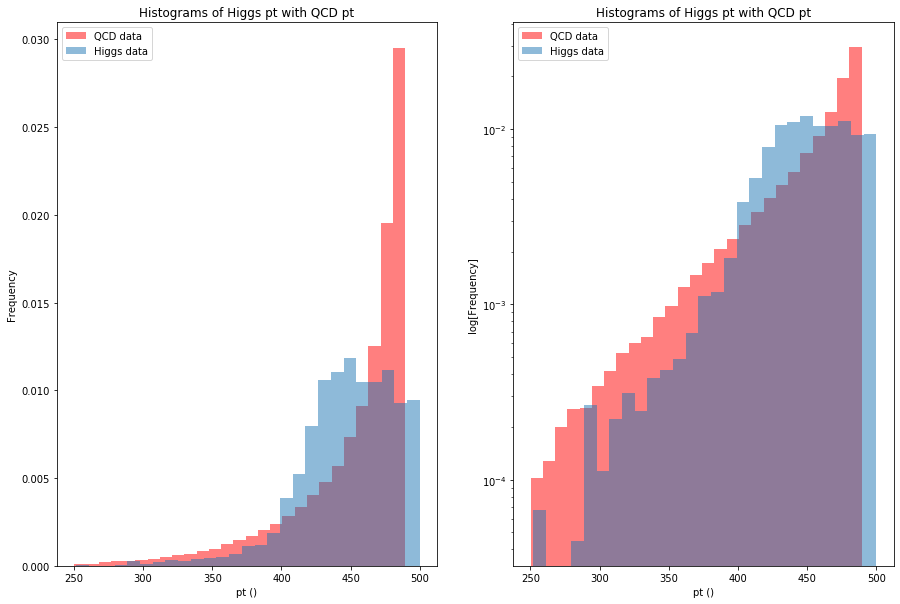

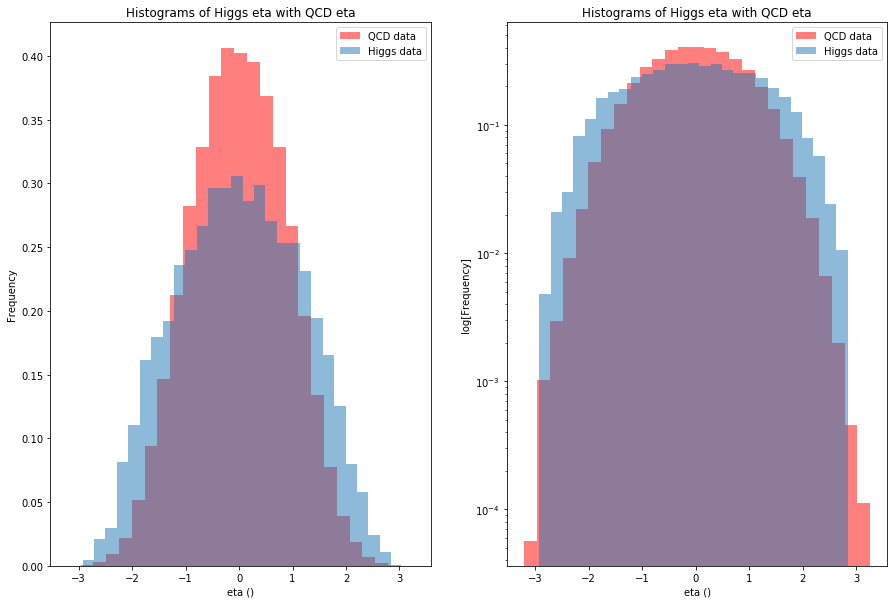

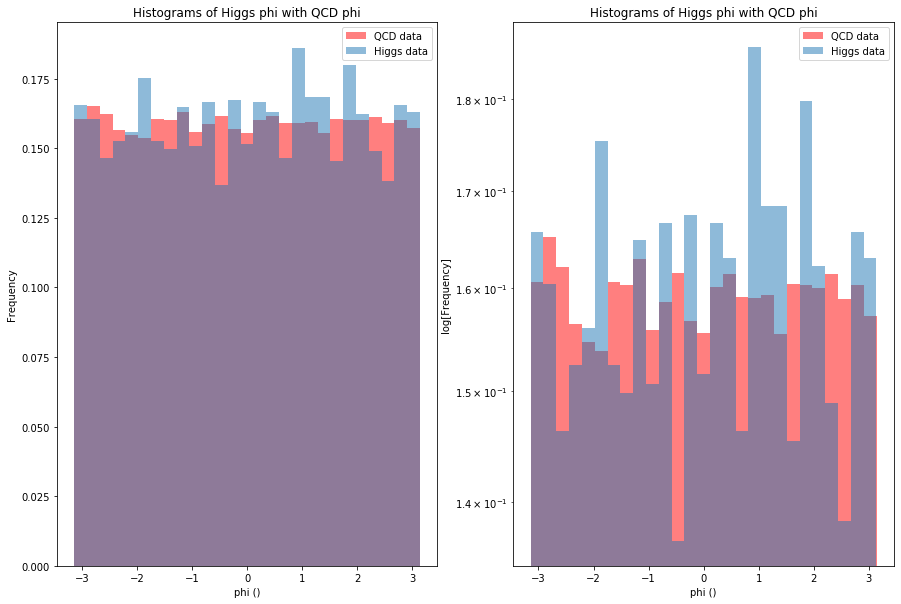

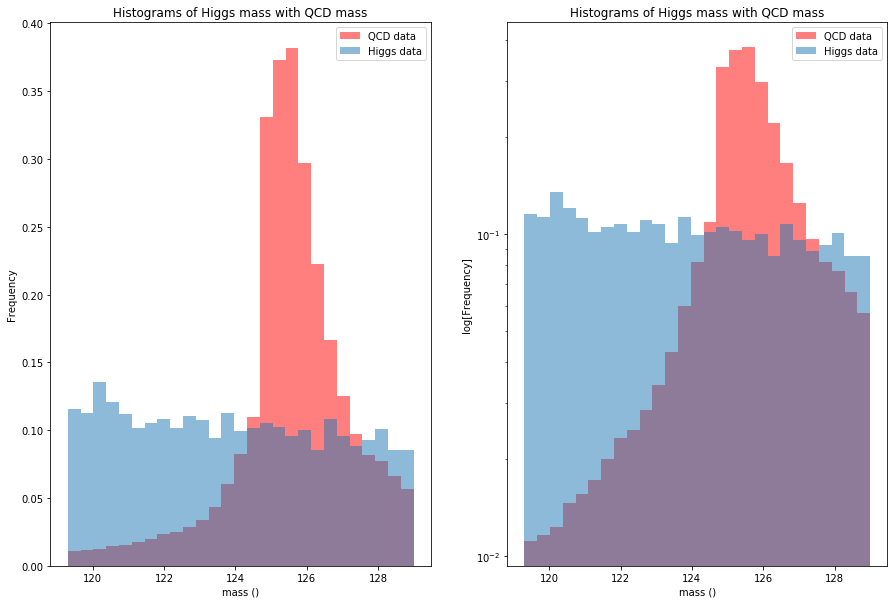

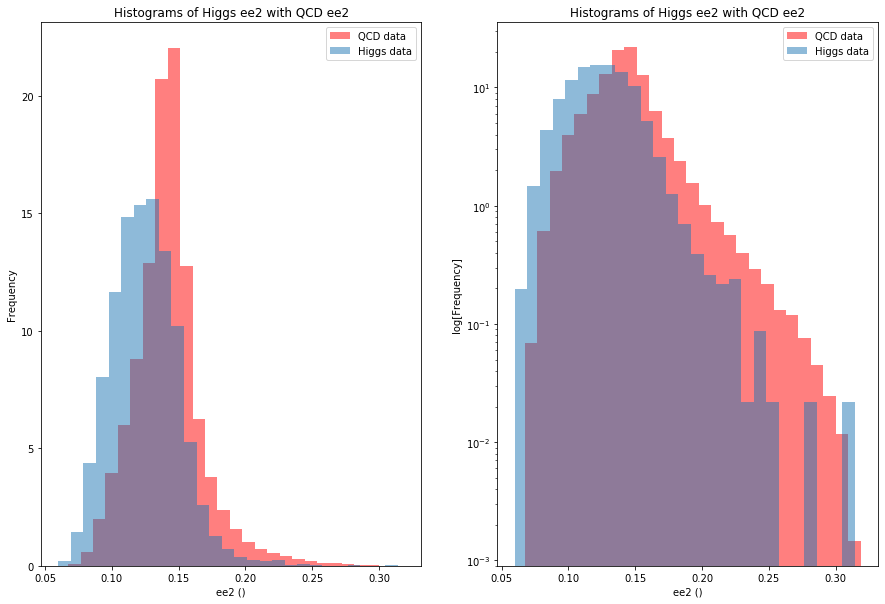

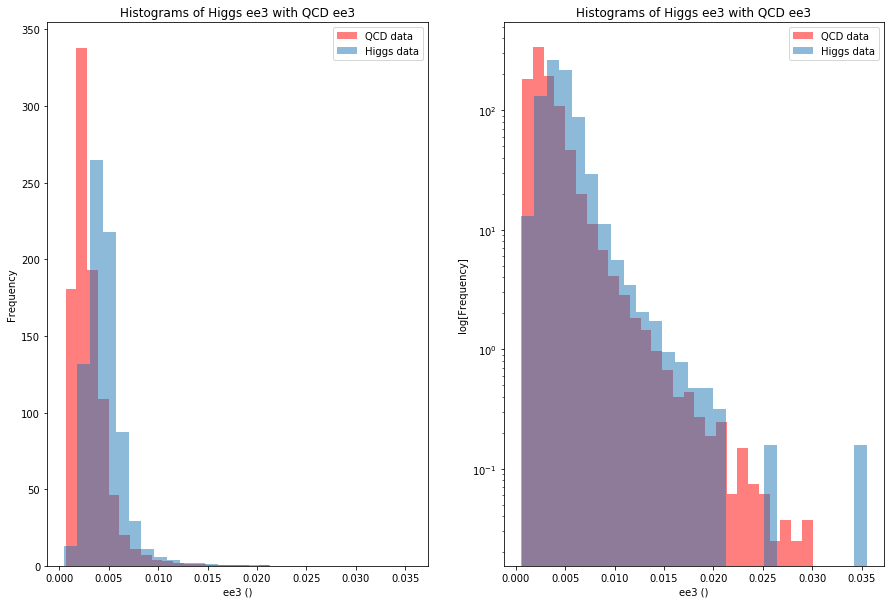

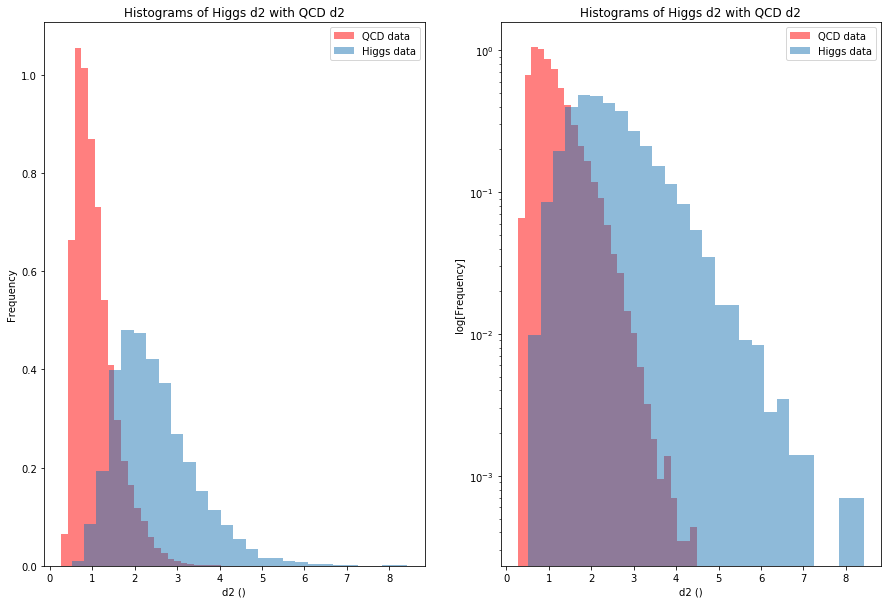

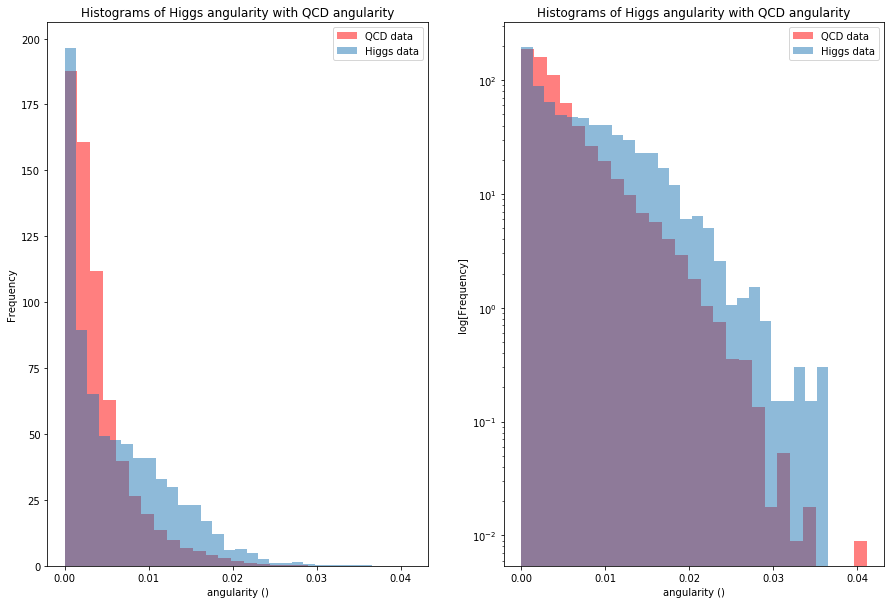

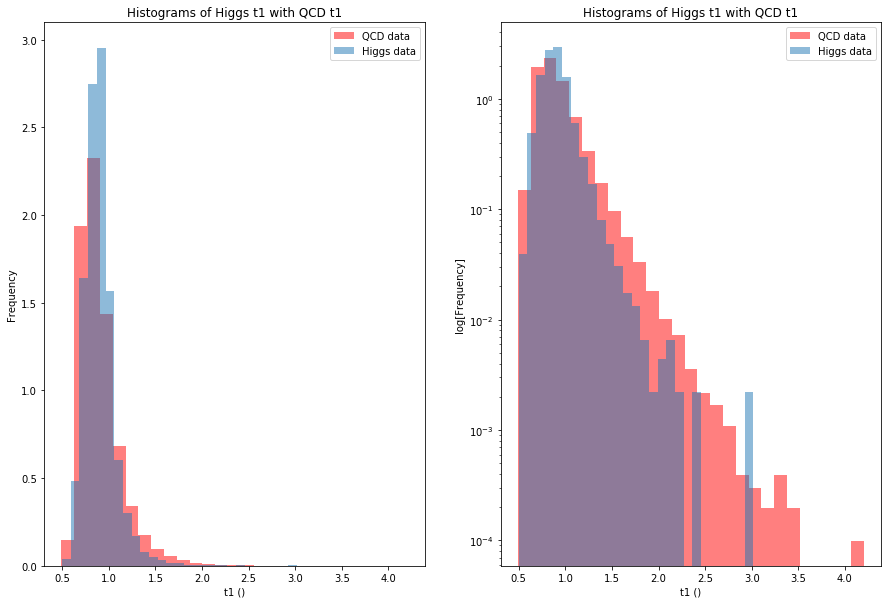

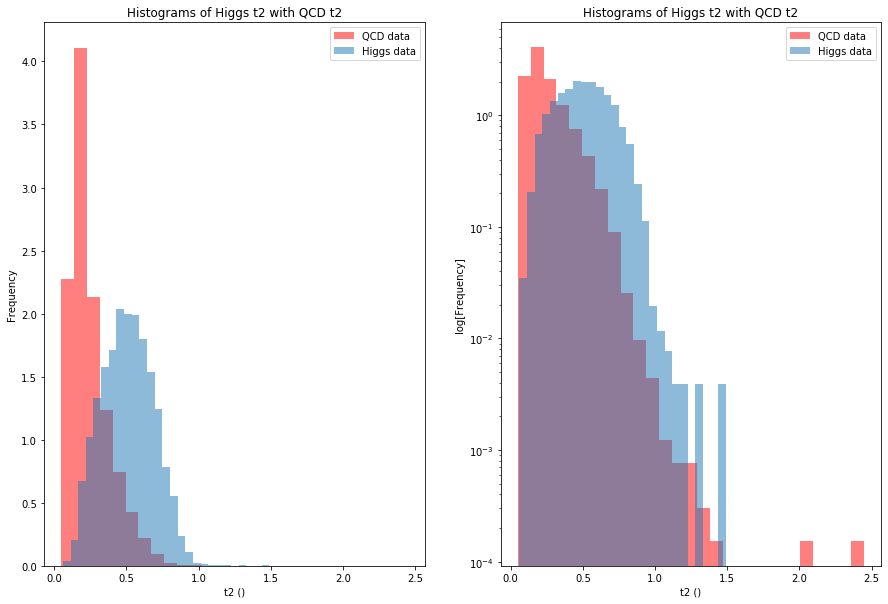

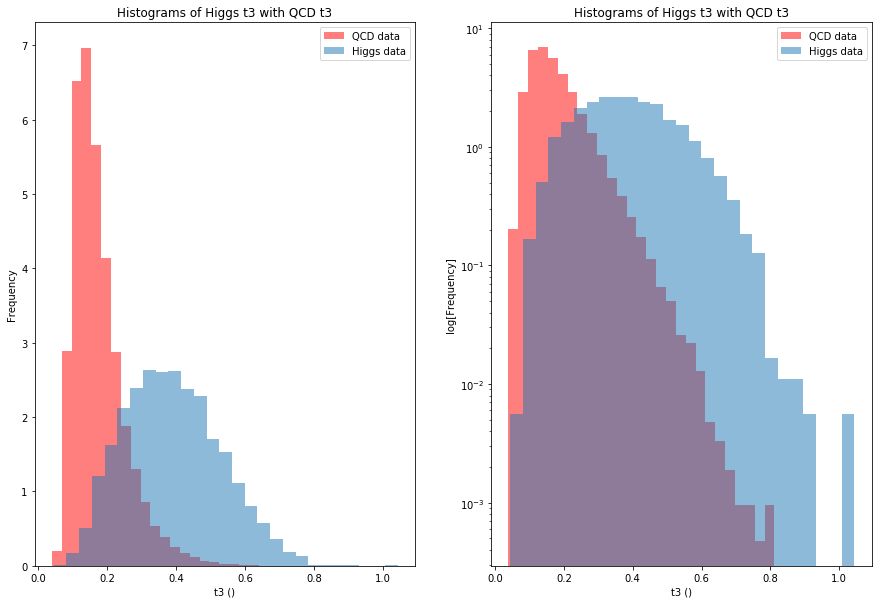

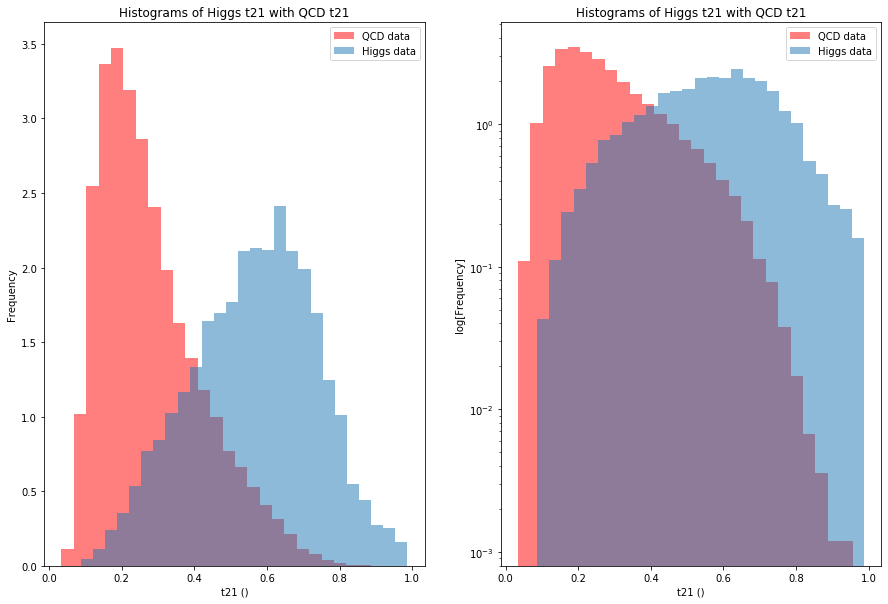

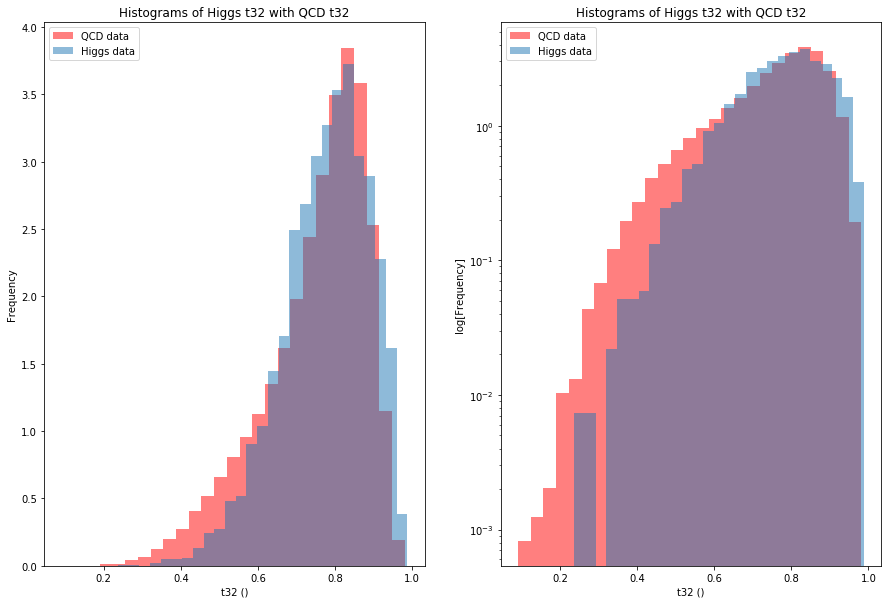

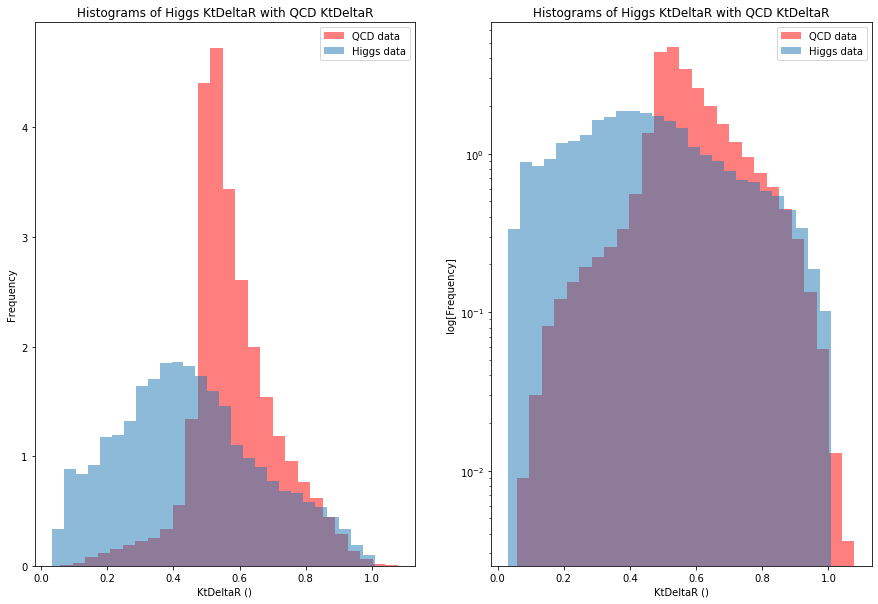

In [19]:
for var in qcd_data.keys():
    histograms_2(higgs_cuts[var], qcd_cuts[var], var, 27)

Of these variables, it appears that t2, t3, and KtDeltaR have significantly different distributions between the Higgs data and the QCD data, this means that we can make additional cuts based on these variables.

In [88]:
# make cuts on: t2, t3, t21, KtDeltaR
def make_cuts(x, y, min_start, max_start):
    min_higgs = 25
    interval = (max_start - min_start) / 1000
    cut_level = min_start
    minimum_cut_level = min_start
    minimum_cut_sig = 1
    significance = 1

    while cut_level < max_start:
        cut_level += interval
        higgs_count = np.count_nonzero(x > cut_level) / weight_higgs
        qcd_count = np.count_nonzero(y > cut_level) / weight_qcd 
        significance = stats.poisson.sf(higgs_count + qcd_count, mu=qcd_count)
        
        if higgs_count > min_higgs and significance < minimum_cut_sig and higgs_count > 0.0 and qcd_count > 0.0:
            minimum_cut_sig = significance
            minimum_cut_level = cut_level


    max_cut_level = max_start
    max_cut_sig = 1
    cut_level = max_start
    sn_ratio = 1
    while cut_level > minimum_cut_level:
        cut_level -= interval
        higgs_count = np.count_nonzero((x > minimum_cut_level) & (x < cut_level)) / weight_higgs
        qcd_count = np.count_nonzero((y > minimum_cut_level) & (y < cut_level)) / weight_qcd 
        significance = stats.poisson.sf(higgs_count + qcd_count, mu=qcd_count)
        
        if higgs_count > min_higgs and significance < max_cut_sig and higgs_count > 0.0 and qcd_count > 0.0:
            max_cut_level = cut_level
            max_cut_sig = significance


    higgs_count = np.count_nonzero((x > minimum_cut_level) & (x < max_cut_level)) / weight_higgs
    qcd_count = np.count_nonzero((y > minimum_cut_level) & (y < max_cut_level)) / weight_qcd 
    significance = stats.poisson.sf(higgs_count + qcd_count, mu=qcd_count)
    print('Min Cut Level:\t\t', np.round(minimum_cut_level, decimals=int(-1*np.log10(interval))))
    print('Max Cut Level:\t\t', np.round(max_cut_level, decimals=int(-1*np.log10(interval))))
    print('Significance:\t\t', significance)
    print('Higgs Counts:\t\t',int(higgs_count))
    print('QCD Counts:\t\t',int(qcd_count))
    
    return [minimum_cut_level, max_cut_level]

In [177]:
variables = ['t2', 't3', 't21', 'KtDeltaR']

print('t2')
print()
[t2_min, t2_max] = make_cuts(np.array(higgs_cuts['t2']), np.array(qcd_cuts['t2']), 0, 1.5)
print()
print()

print('t3')
print()
[t3_min, t3_max] = make_cuts(np.array(higgs_cuts['t3']), np.array(qcd_cuts['t3']), 0, 0.8)
print()
print()

print('t21')
print()
[t21_min, t21_max] = make_cuts(np.array(higgs_cuts['t21']), np.array(qcd_cuts['t21']), 0, 0.8)
print()
print()

print('KtDeltaR')
[kt_min, kt_max] = make_cuts(np.array(higgs_cuts['KtDeltaR']), np.array(qcd_cuts['KtDeltaR']), 0, 1)
print()
print()

t2

Min Cut Level:		 0.0
Max Cut Level:		 0.18
Significance:		 3.382496358208138e-09
Higgs Counts:		 28
QCD Counts:		 17


t3

Min Cut Level:		 0.001
Max Cut Level:		 0.146
Significance:		 2.009977044110359e-10
Higgs Counts:		 31
QCD Counts:		 17


t21

Min Cut Level:		 0.001
Max Cut Level:		 0.222
Significance:		 3.047308959227119e-08
Higgs Counts:		 30
QCD Counts:		 24


KtDeltaR
Min Cut Level:		 0.463
Max Cut Level:		 0.842
Significance:		 0.0007647775383717723
Higgs Counts:		 63
QCD Counts:		 383




Now I can combine these cuts with the mass cuts that I previously made

In [187]:
# this block of code iterates through all of the mass data and compiles the other variables where the mass is eithin the predefined cut

final_higgs_cuts = {'pt' : [], 'eta' : [], 'phi' : [], 'mass' : [], 'ee2' : [], 'ee3' : [], 'd2' : [], 'angularity' : [], 't1' : [],
       't2' : [], 't3' : [], 't21' : [], 't32' : [], 'KtDeltaR' : []}
final_qcd_cuts = {'pt' : [], 'eta' : [], 'phi' : [], 'mass' : [], 'ee2' : [], 'ee3' : [], 'd2' : [], 'angularity' : [], 't1' : [],
       't2' : [], 't3' : [], 't21' : [], 't32' : [], 'KtDeltaR' : []}

for index in range(len(higgs_cuts.get('mass'))):
    
    is_higgs = higgs_cuts.get('t2')[index] < t2_max and higgs_cuts.get('t2')[index] > t2_min
    is_higgs = is_higgs and higgs_cuts.get('t3')[index] < t3_max and higgs_cuts.get('t3')[index] > t3_min 
    is_higgs = is_higgs and higgs_cuts.get('t21')[index] < t21_max and higgs_cuts.get('t21')[index] > t21_min
    # is_higgs = is_higgs and higgs_cuts.get('KtDeltaR')[index] < kt_max and higgs_cuts.get('KtDeltaR')[index] > kt_min
    if is_higgs:
        for var in higgs_data.keys():
            final_higgs_cuts.get(var).append(higgs_cuts.get(var)[index])
     
for index in range(len(qcd_cuts.get('mass'))):
    is_qcd = qcd_cuts.get('t2')[index] < t2_max and qcd_cuts.get('t2')[index] > t2_min
    is_qcd = is_qcd and qcd_cuts.get('t3')[index] < t3_max and qcd_cuts.get('t3')[index] > t3_min 
    is_qcd = is_qcd and qcd_cuts.get('t21')[index] < t21_max and qcd_cuts.get('t21')[index] > t21_min
    # is_qcd = is_qcd and qcd_cuts.get('KtDeltaR')[index] < kt_max and qcd_cuts.get('KtDeltaR')[index] > kt_min
    if is_qcd:
        for var in higgs_data.keys():
            final_qcd_cuts[var].append(qcd_cuts.get(var)[index])

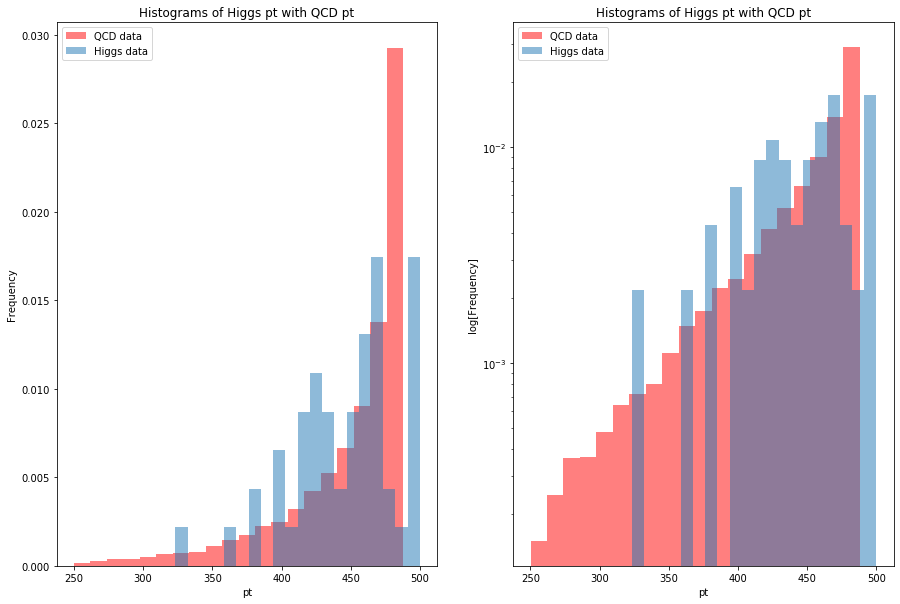

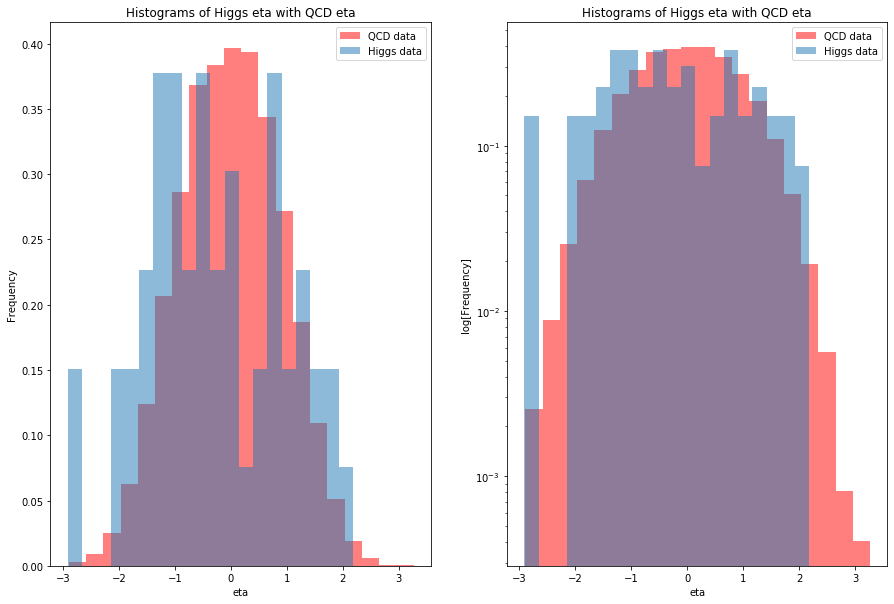

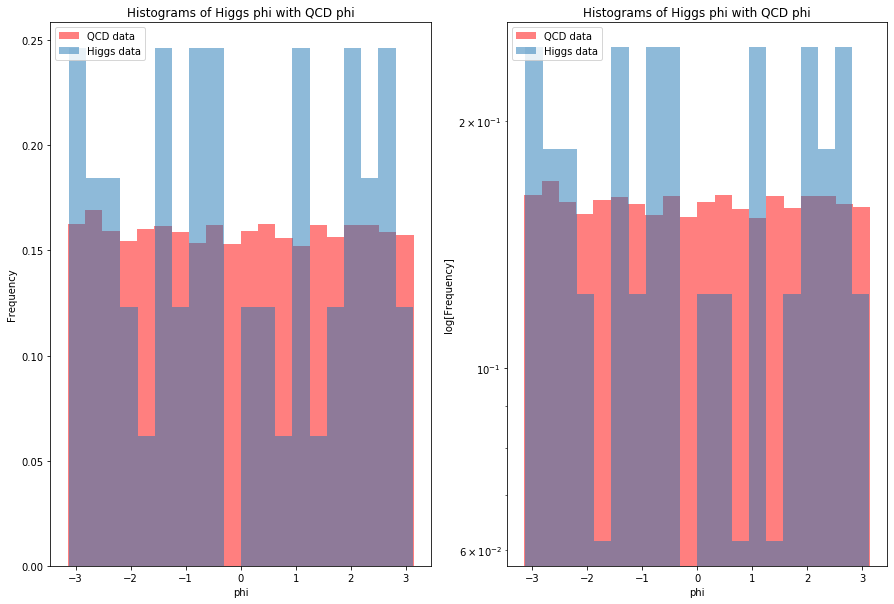

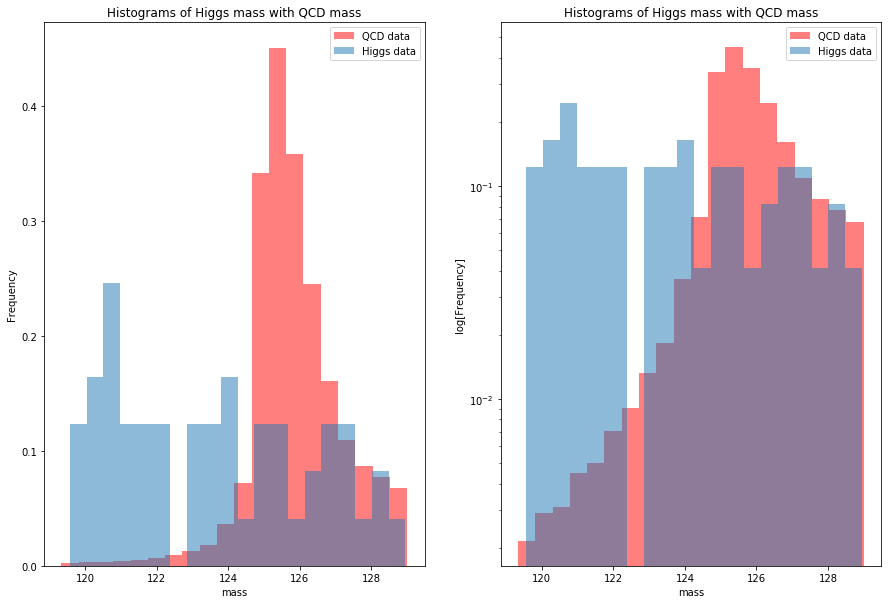

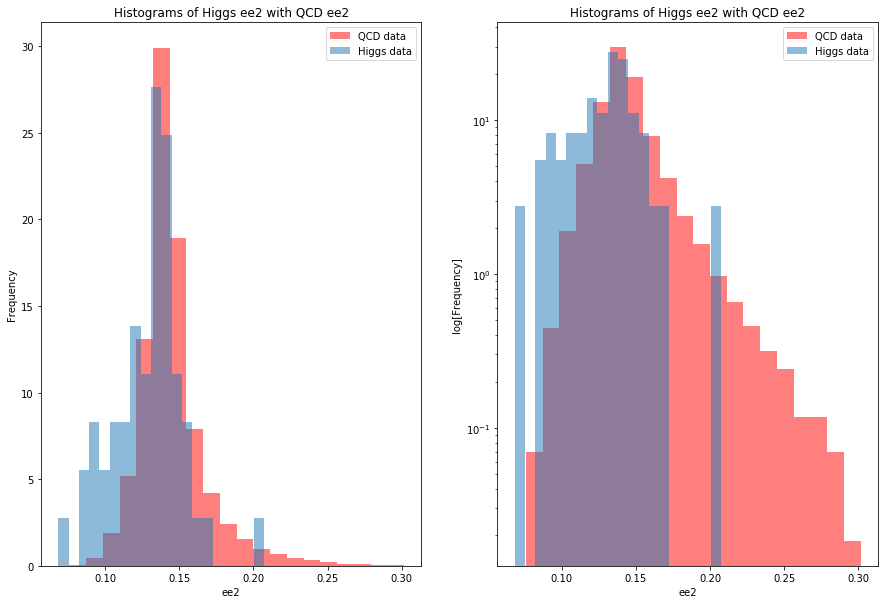

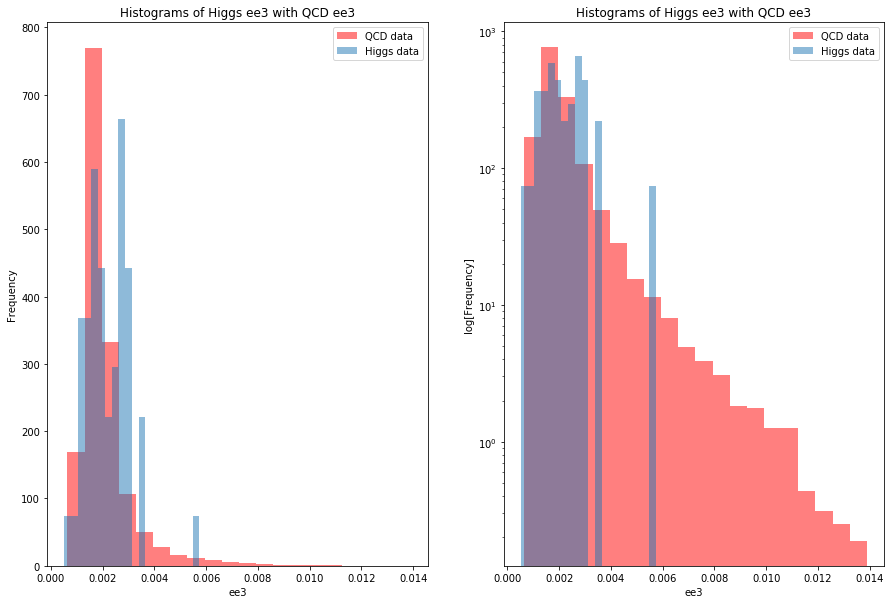

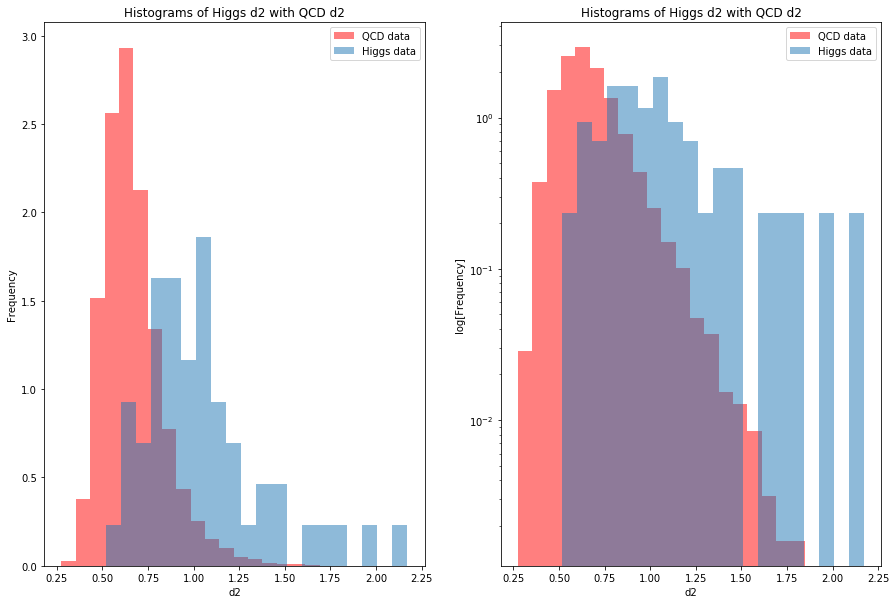

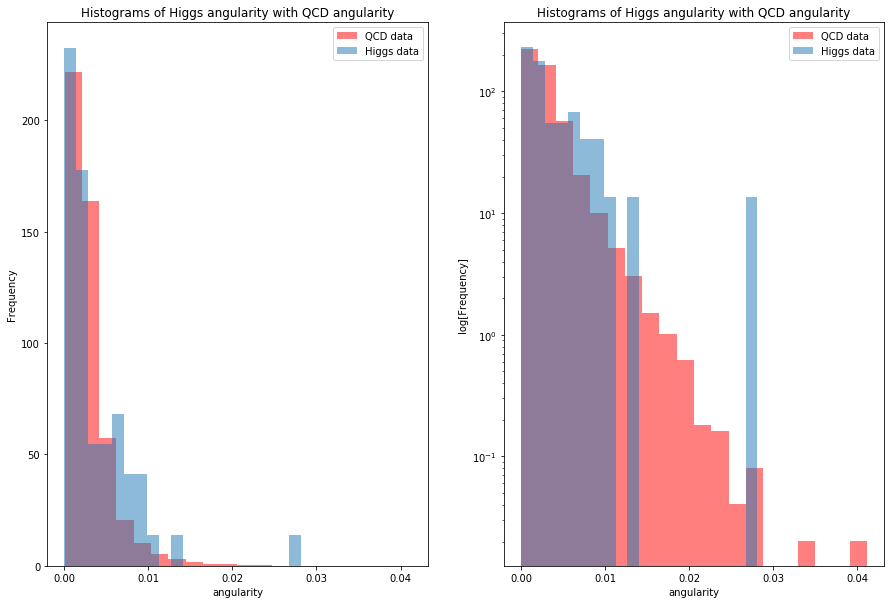

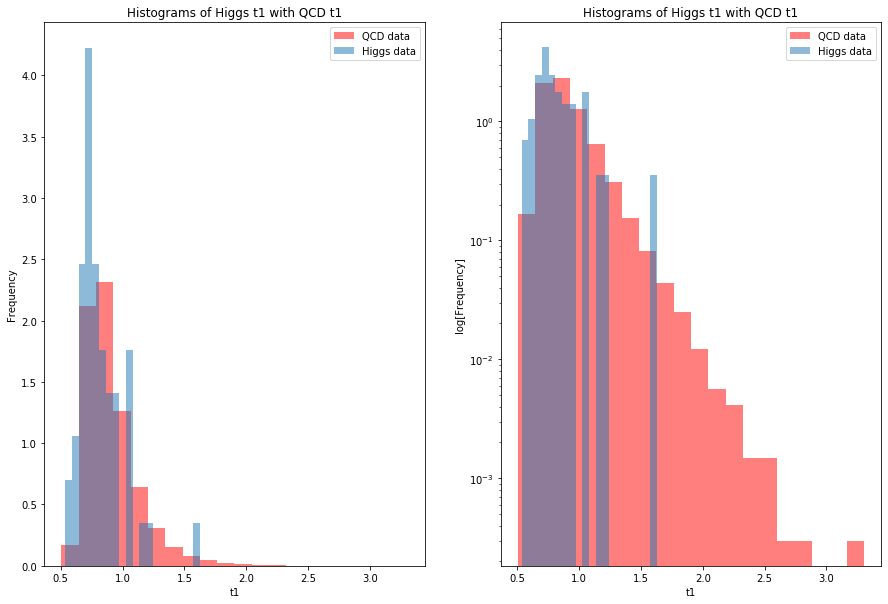

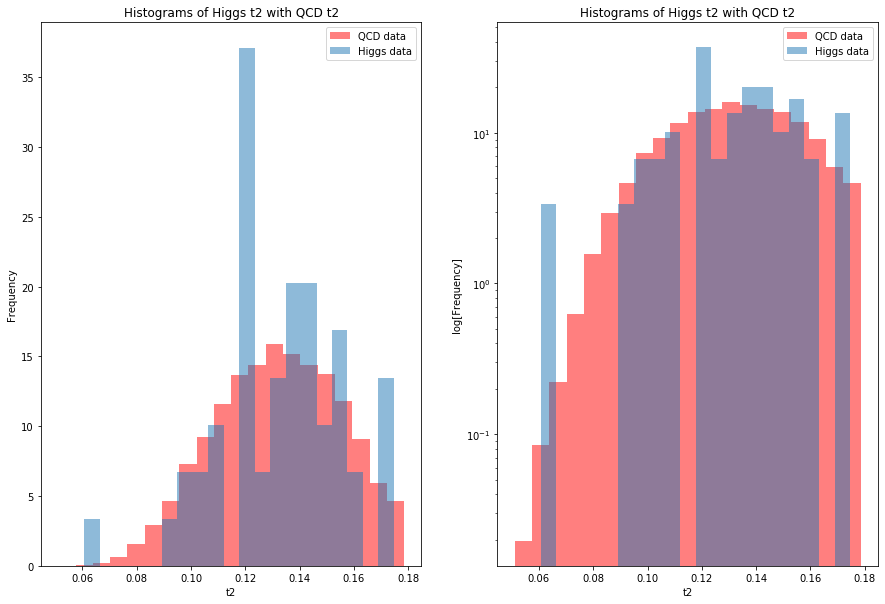

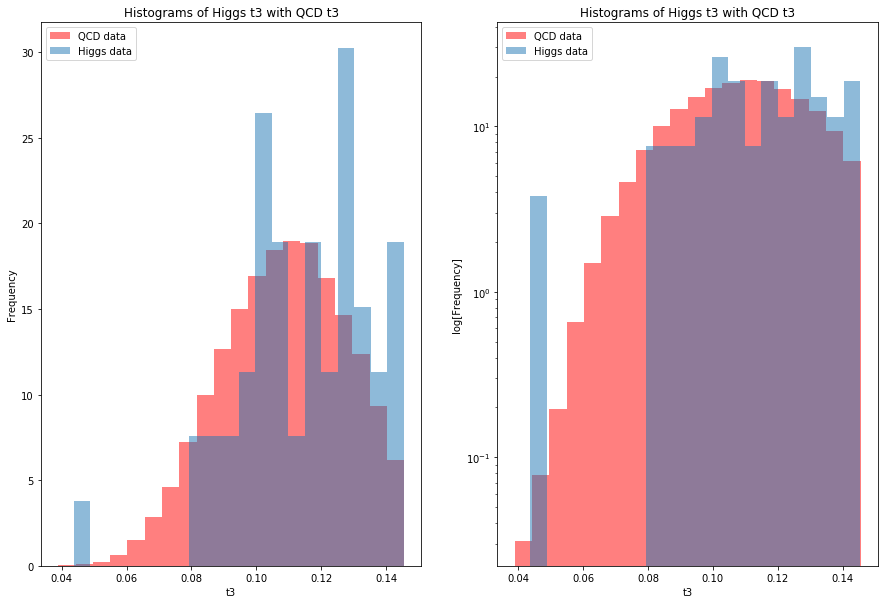

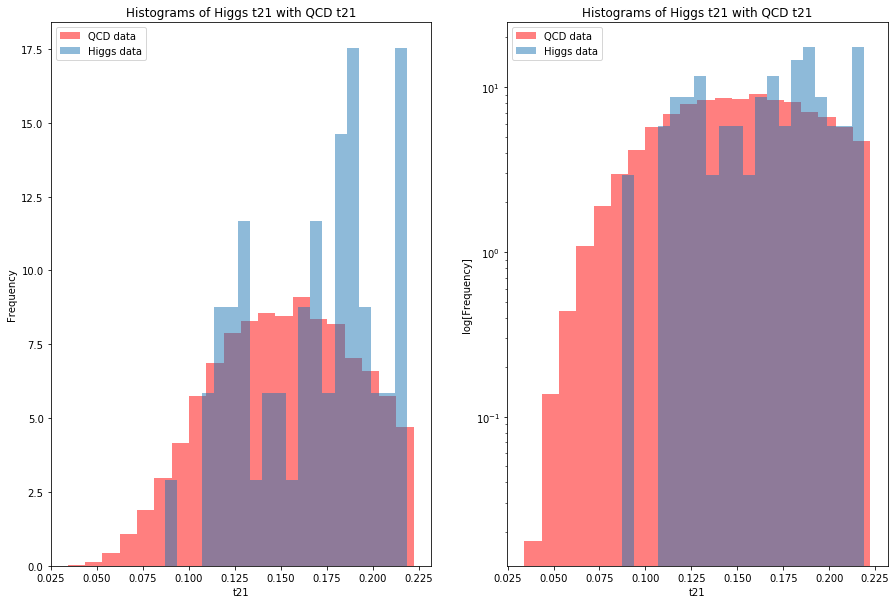

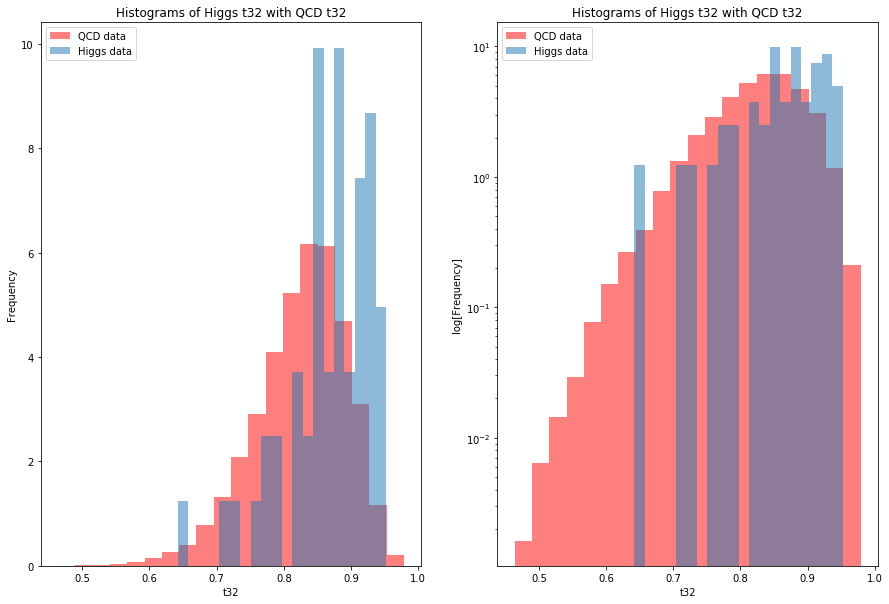

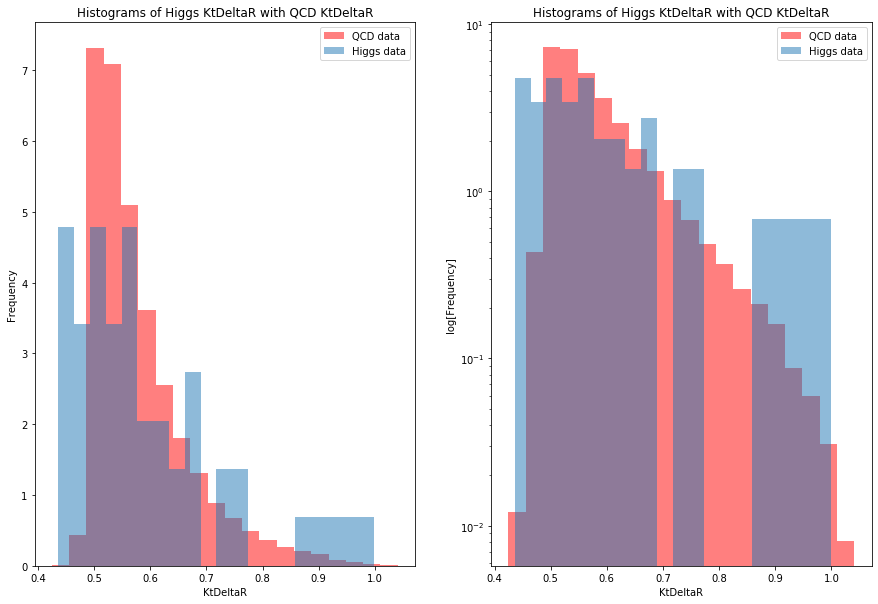

In [188]:
for var in qcd_data.keys():
    histograms_2(np.array(final_higgs_cuts[var]), np.array(final_qcd_cuts[var]), var, 20)

In [189]:
# final significance
higgs_count = len(final_higgs_cuts['mass']) / weight_higgs
qcd_count = len(final_qcd_cuts['mass']) / weight_qcd 
expected_significance = stats.poisson.sf(higgs_count + qcd_count, mu=qcd_count)

print('Higgs Count:\t', int(higgs_count))
print('QCD Count:\t',int(qcd_count))
print('Significance:\t',expected_significance)
sigma = stats.norm.ppf(1-expected_significance)
print('Sigma:\t\t', np.round(sigma, decimals = 2))

Higgs Count:	 24
QCD Count:	 10
Significance:	 1.6273926772775098e-09
Sigma:		 5.92


So now the data is cut to the point to where we a discovery is significant.

# Lab 8

## High luminosity data

In [115]:
import pandas as pd

high_lum_data = pd.read_hdf('data_highLumi_pt_250_500.h5')
low_lum_data = pd.read_hdf('data_lowLumi_pt_250_500.h5')

high_lum_data.keys()

Index(['pt', 'eta', 'phi', 'mass', 'ee2', 'ee3', 'd2', 'angularity', 't1',
       't2', 't3', 't21', 't32', 'KtDeltaR'],
      dtype='object')

In [196]:
def histograms_3(x_1, x_2, x_3, name, bins):
    plt.rcParams["figure.figsize"] = (15,10)  
    fig, ax = plt.subplots(1, 2)

    ax[0].hist(x_1, color = 'red', alpha=0.5, label = 'Expected data', bins = bins, density = True)
    ax[0].hist(x_2, alpha=0.5, label='Background data', bins = bins, density = True)
    ax[0].hist(x_3, alpha=0.5, label='Higgs data', bins = bins, density=True)
    ax[1].hist(x_1, color = 'red', alpha=0.5, label = 'Expected data', bins = bins, density = True)
    ax[1].hist(x_2, alpha=0.5, label='Background data', bins = bins, density = True)
    ax[1].hist(x_3, alpha=0.5, label='Higgs data', bins = bins, density=True)

    ax[0].set_title('Histograms of Expected ' + name + ' with Background '+ name)
    ax[0].set_ylabel('Frequency')
    ax[0].set_xlabel(name)
    ax[0].legend()

    ax[1].set_title('Histograms of Expected ' + name + ' with Background '+ name)
    ax[1].set_ylabel('log[Frequency]')
    ax[1].set_xlabel(name)
    ax[1].legend()
    ax[1].set_yscale('log')
    
    return ax

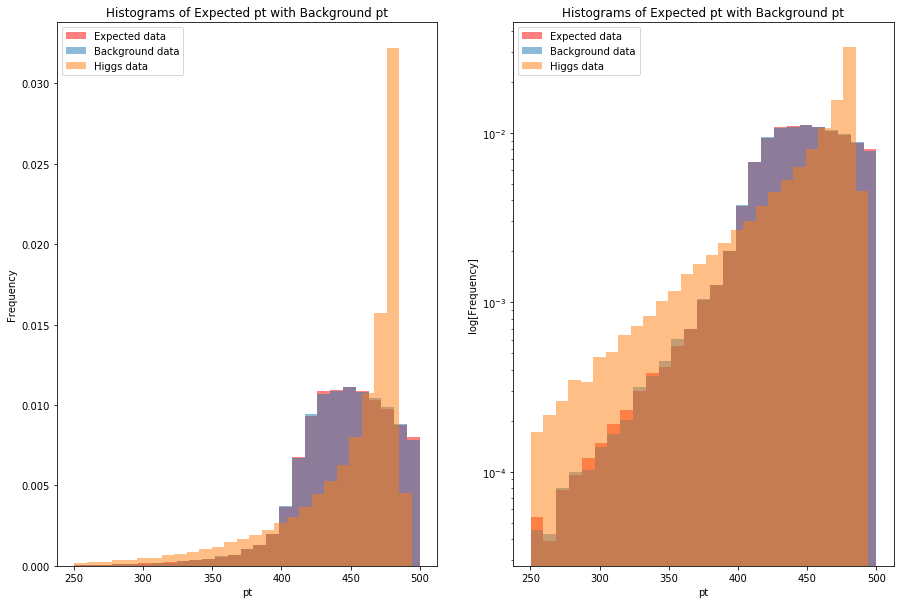

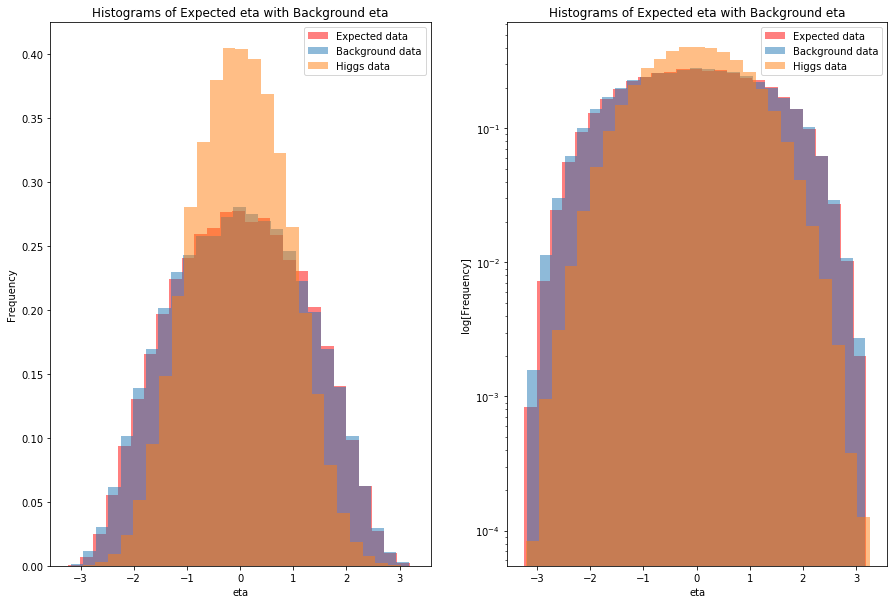

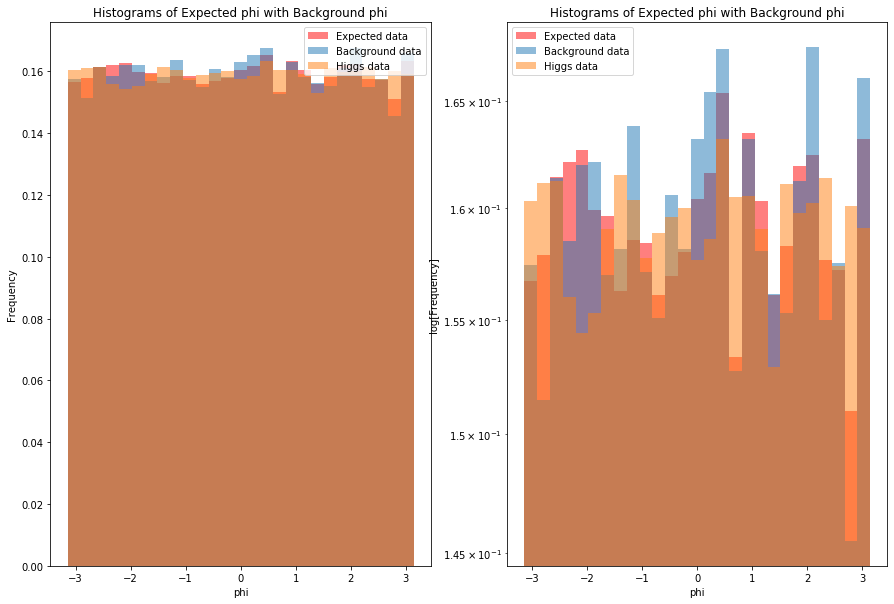

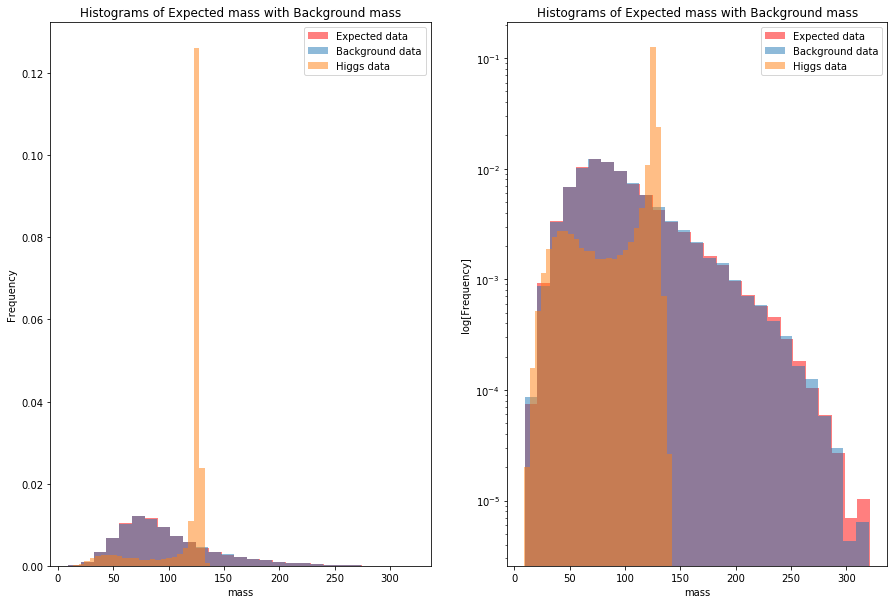

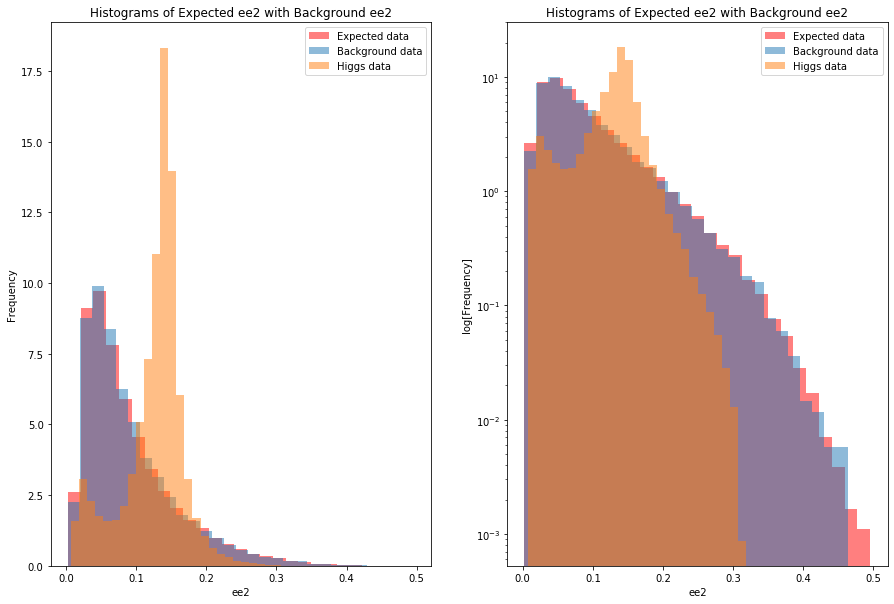

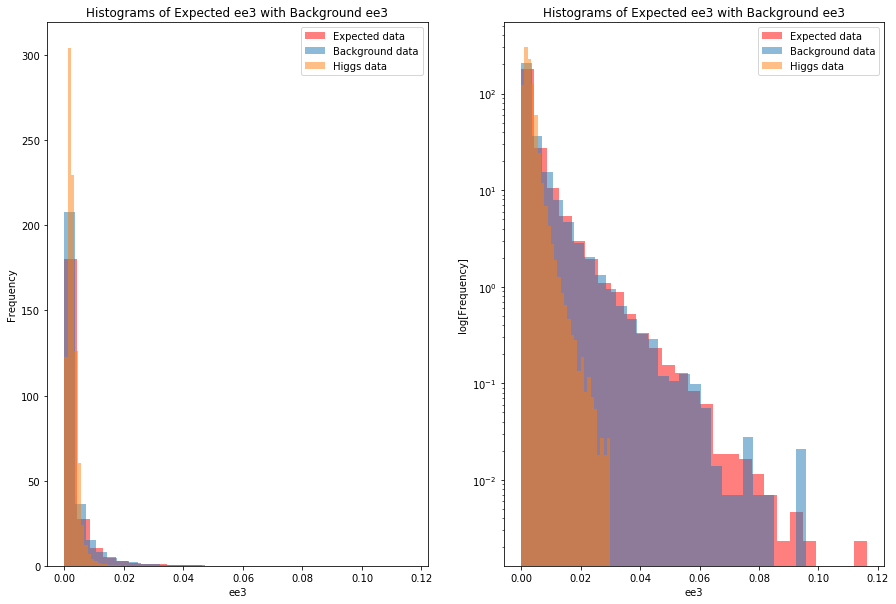

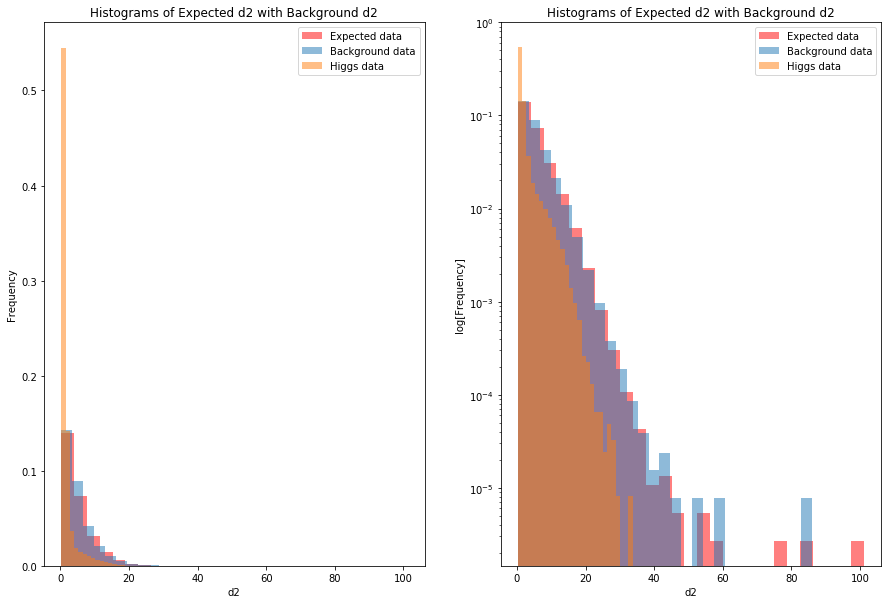

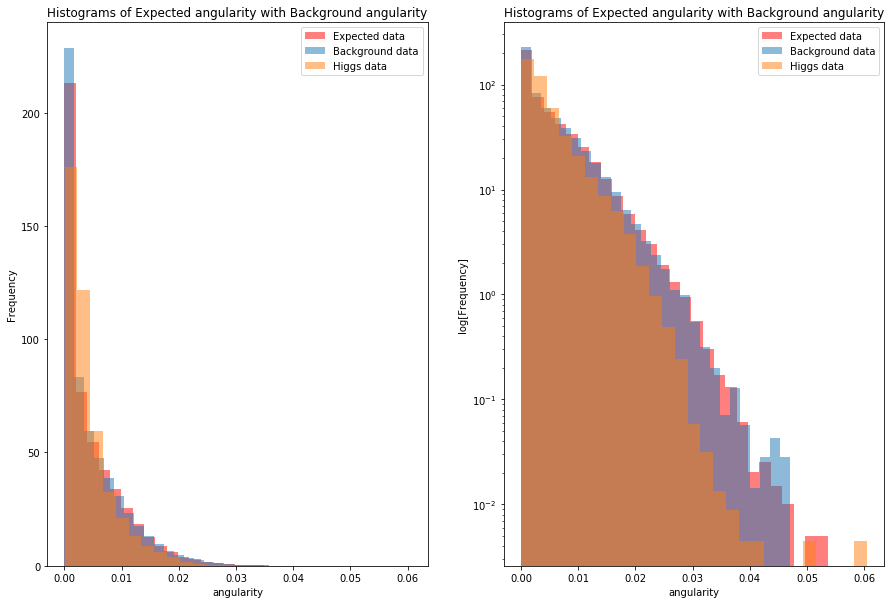

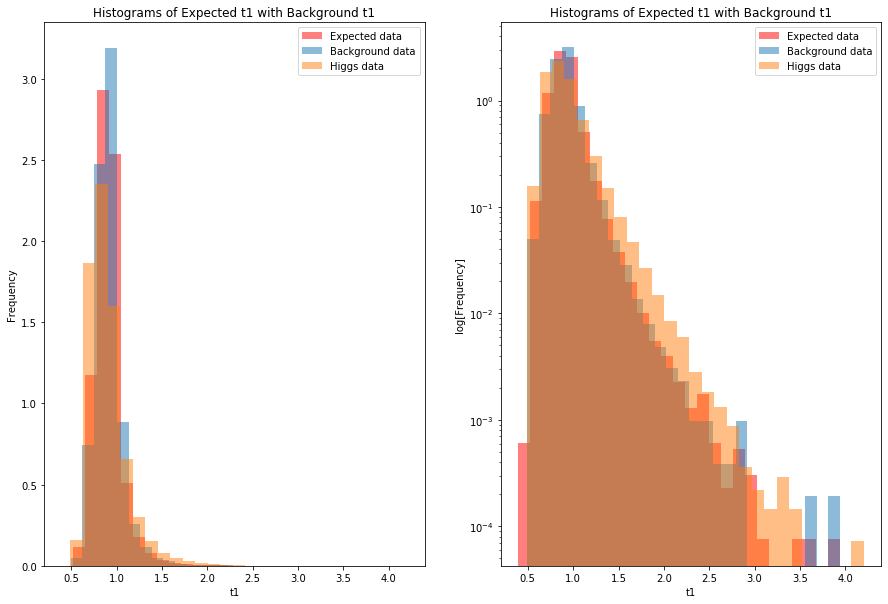

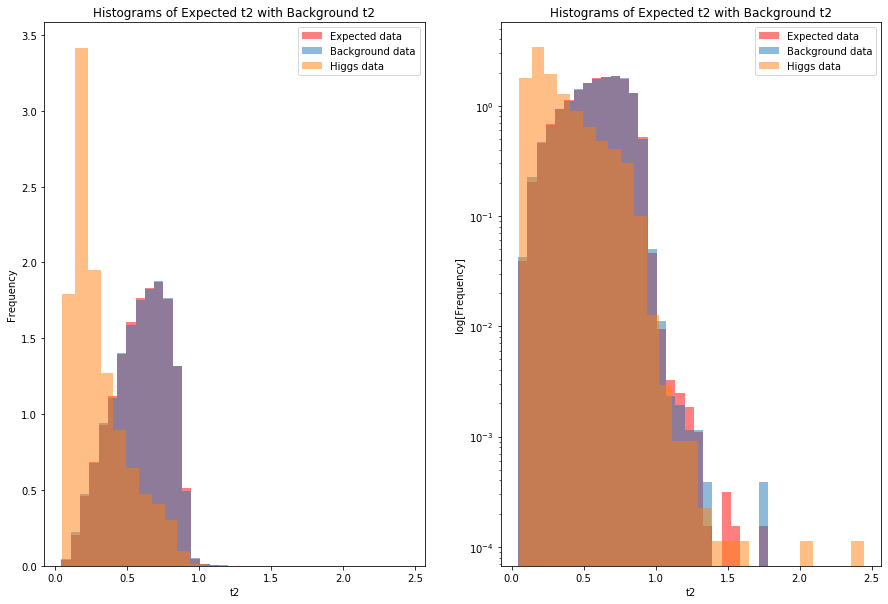

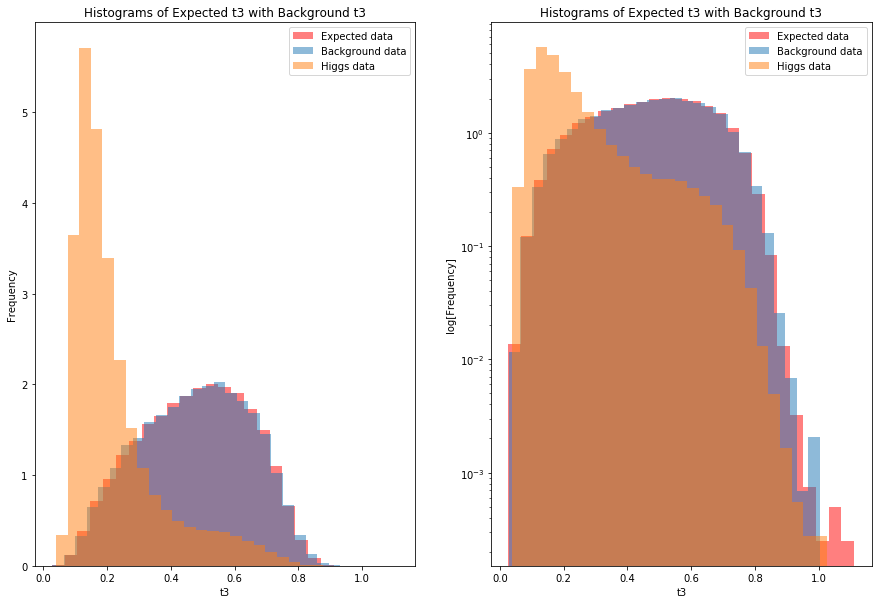

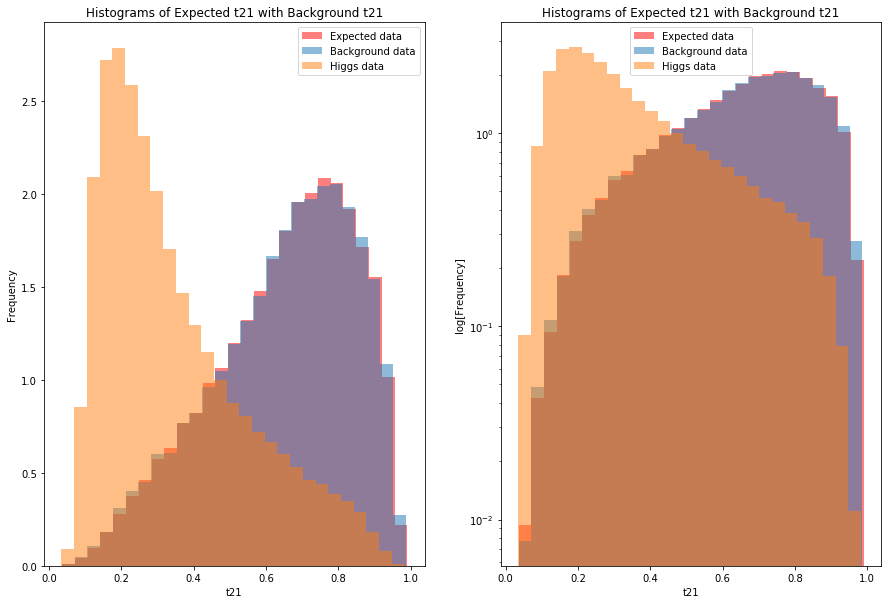

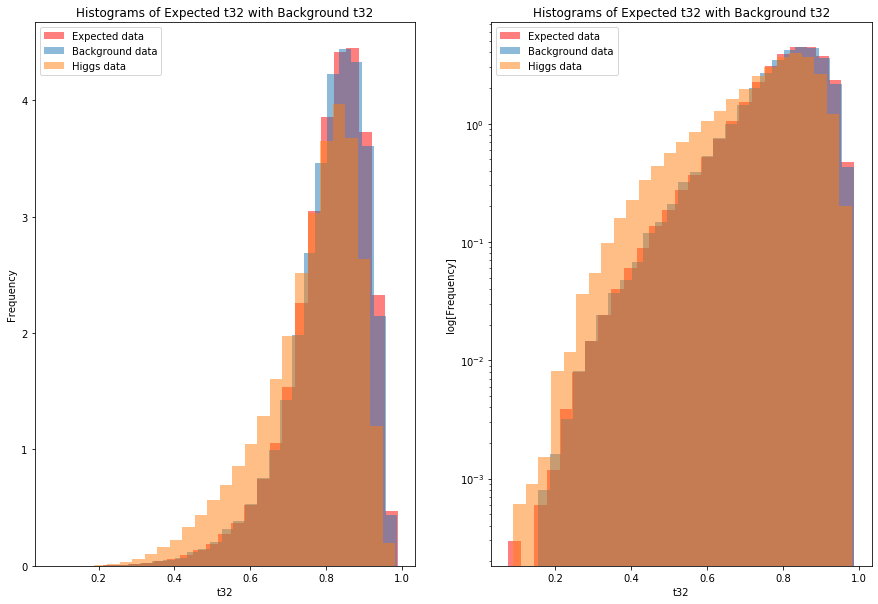

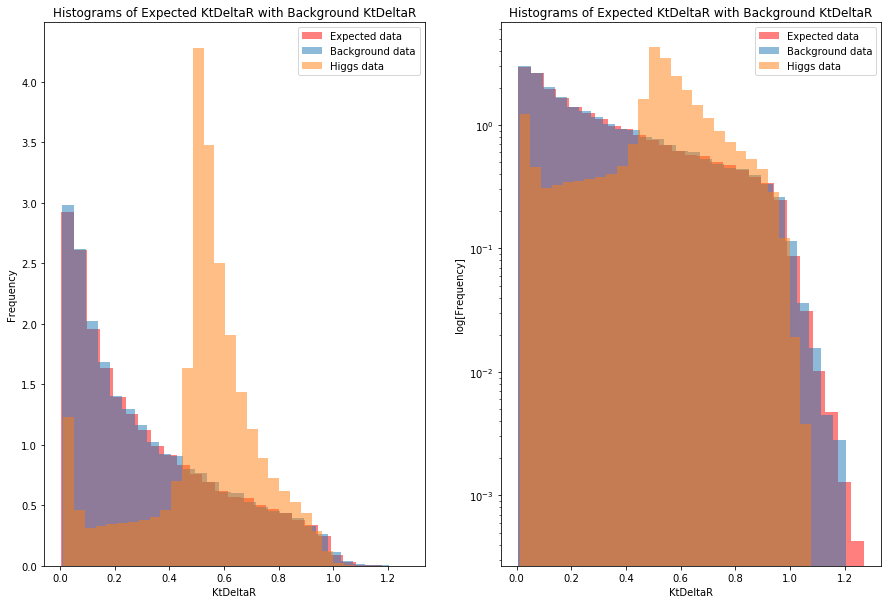

In [197]:
for var in high_lum_data.keys():
    histograms_3(qcd_data.get(var), high_lum_data.get(var), higgs_data.get(var), var, 27)

In [190]:
def cut_data(data):
    cut_data = {'pt' : [], 'eta' : [], 'phi' : [], 'mass' : [], 'ee2' : [], 'ee3' : [], 'd2' : [], 'angularity' : [], 't1' : [],
           't2' : [], 't3' : [], 't21' : [], 't32' : [], 'KtDeltaR' : []}

    for index in range(len(data.get('mass'))):
        is_higgs = data.get('mass')[index] > mass_min and data.get('mass')[index] < mass_max
        is_higgs = is_higgs and data.get('t2')[index] < t2_max and data.get('t2')[index] > t2_min
        is_higgs = is_higgs and data.get('t3')[index] < t3_max and data.get('t3')[index] > t3_min 
        is_higgs = is_higgs and data.get('t21')[index] < t21_max and data.get('t21')[index] >t21_min
        # is_higgs = is_higgs and data.get('KtDeltaR')[index] < kt_max and data.get('KtDeltaR')[index] > kt_min
        if is_higgs:
            for var in data.keys():
                cut_data.get(var).append(data.get(var)[index])
                
    return cut_data

In [191]:
cut_high_lum = cut_data(high_lum_data)

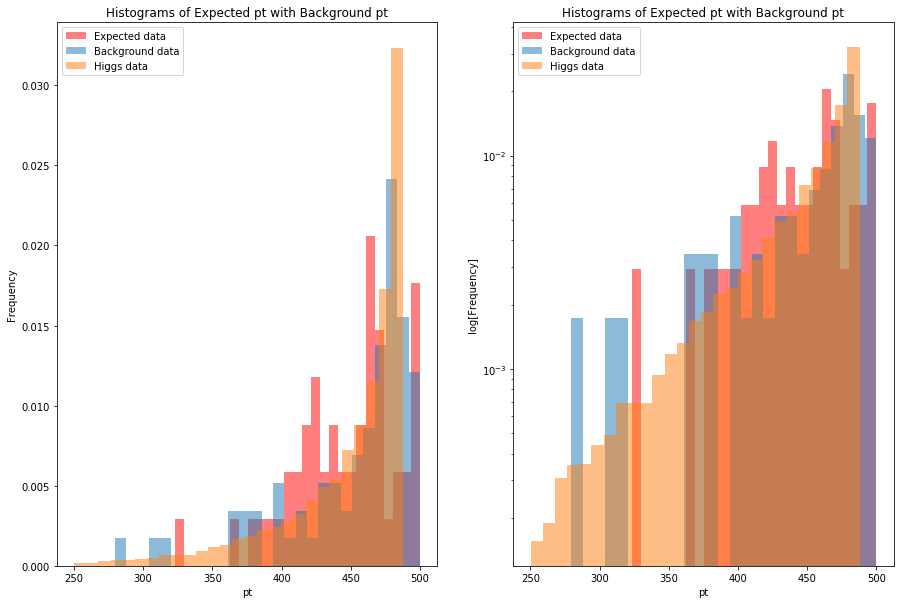

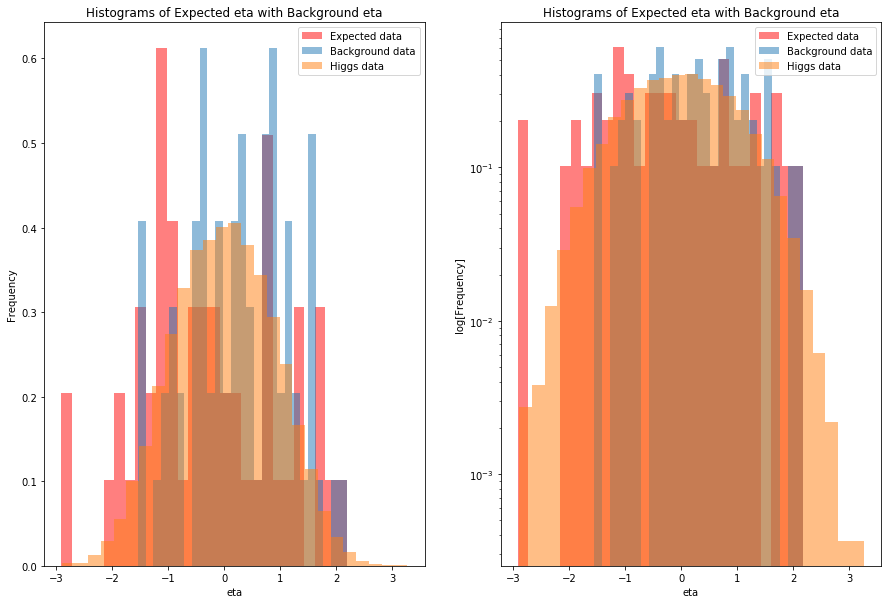

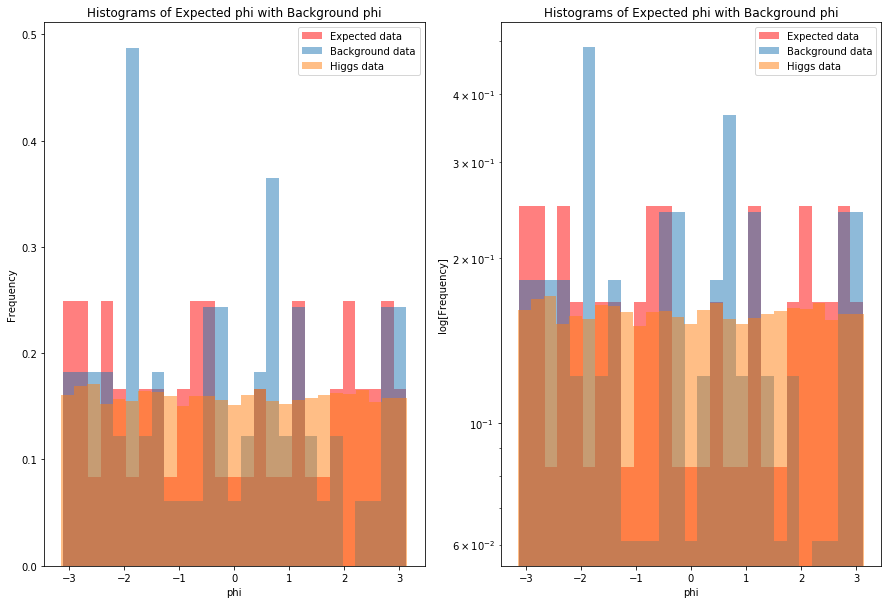

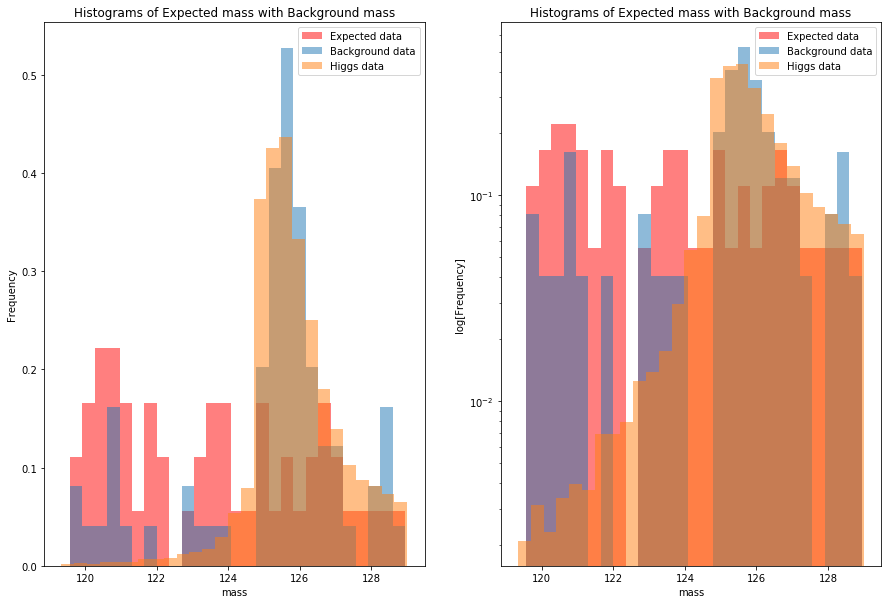

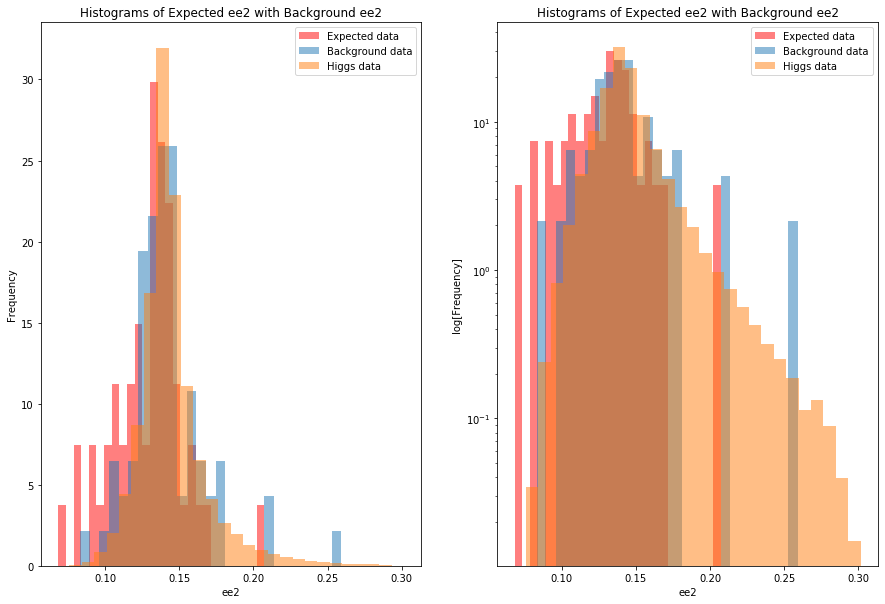

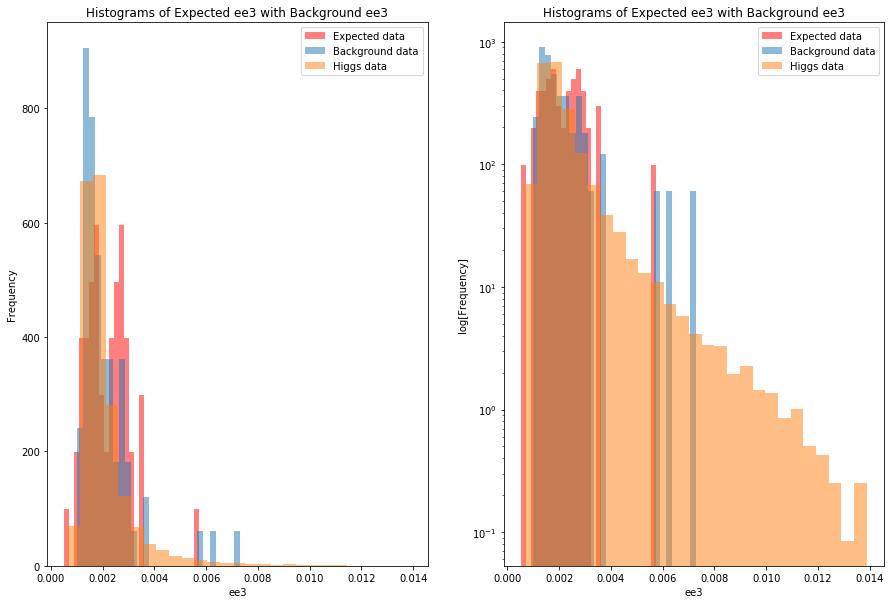

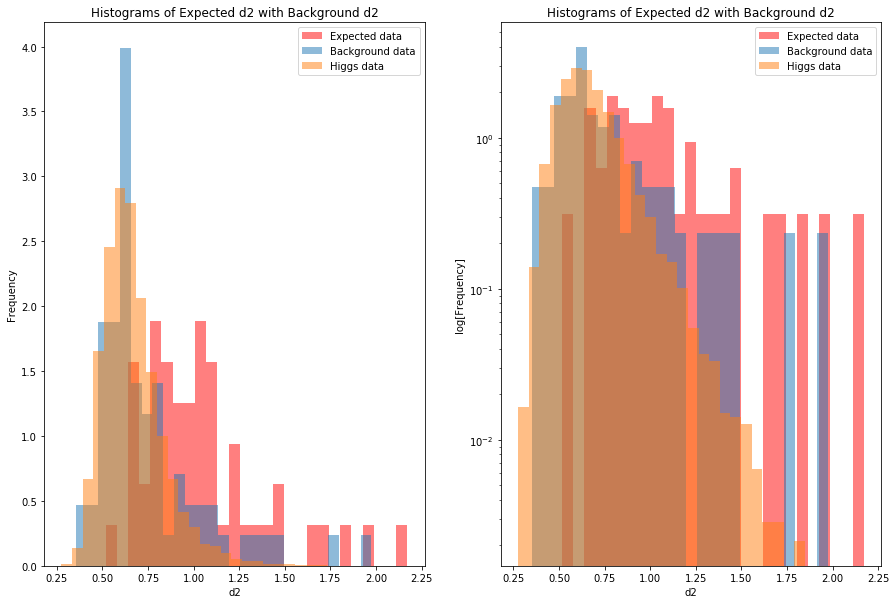

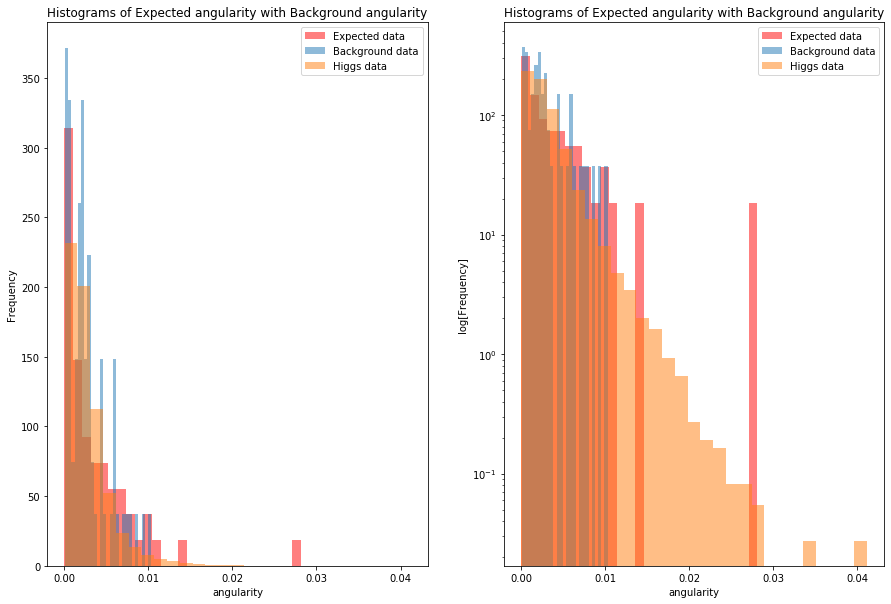

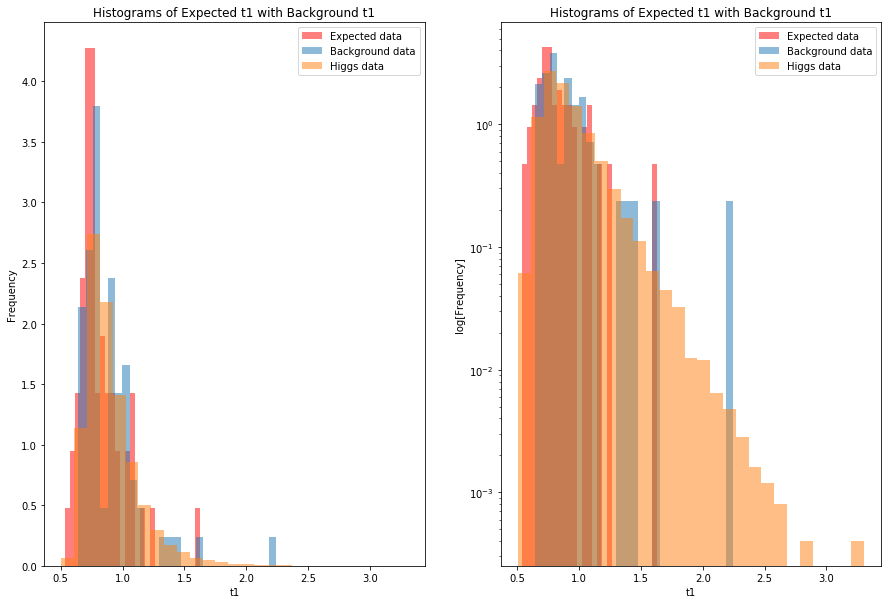

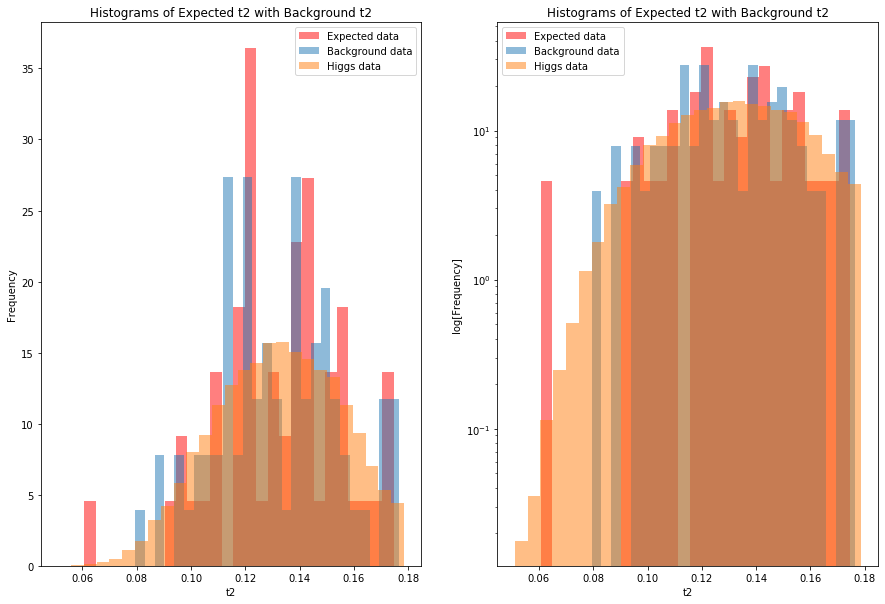

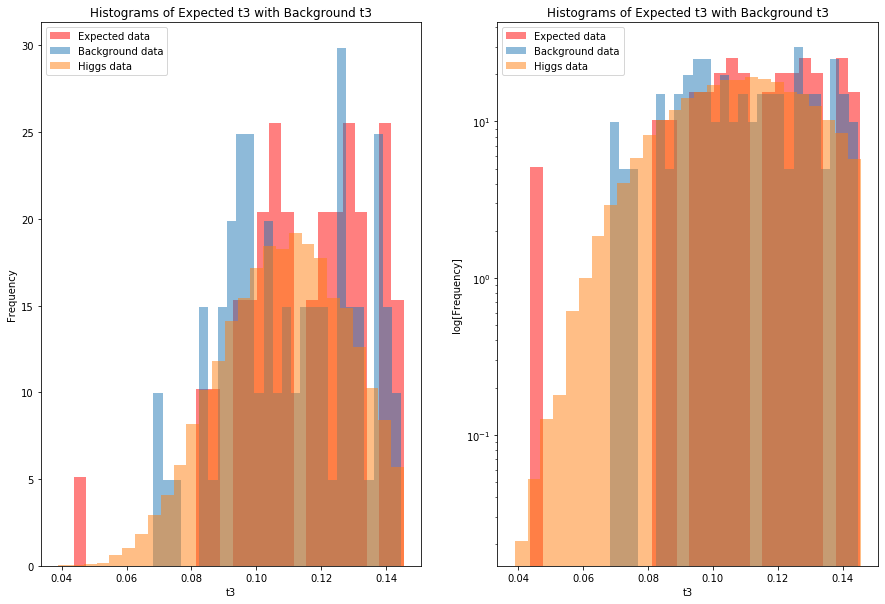

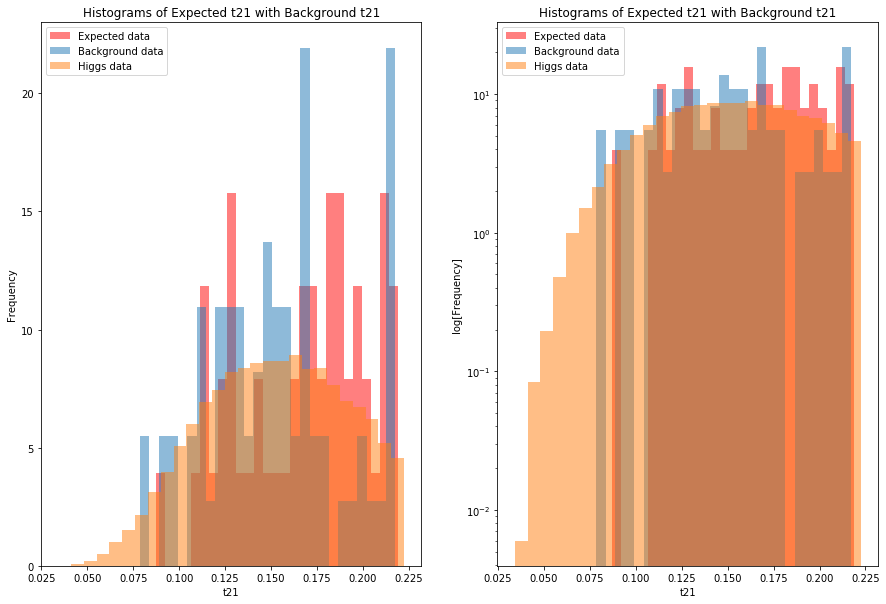

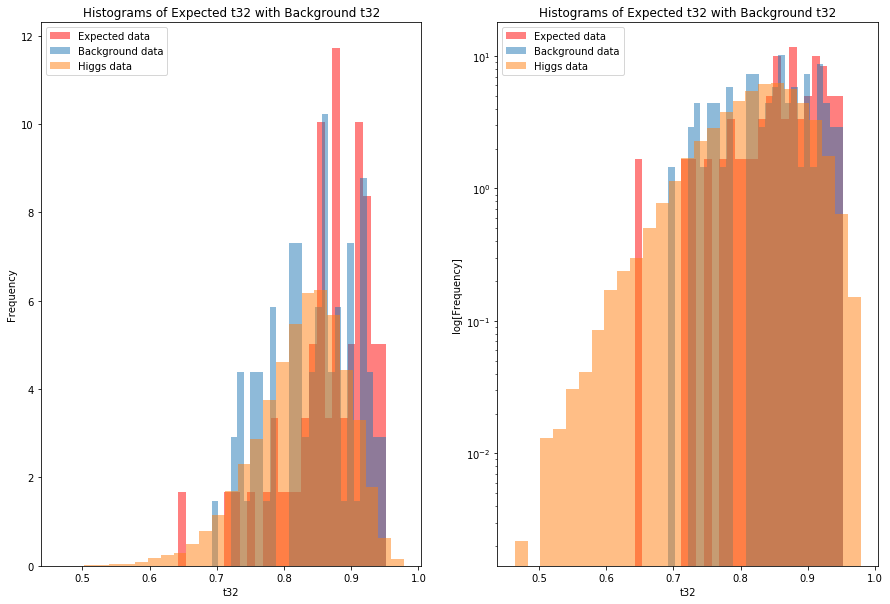

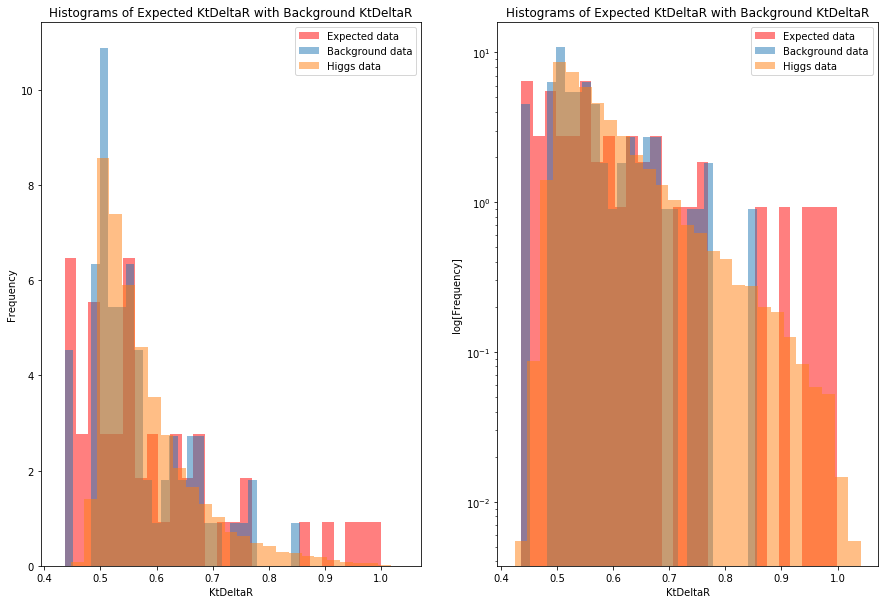

In [199]:
for var in high_lum_data.keys():
    histograms_3(final_qcd_cuts.get(var), cut_high_lum.get(var), final_higgs_cuts.get(var), var, 27)

In [212]:
print('High Lum data size:\t',len(cut_high_lum.get('mass')))
print('QCD data size:\t\t',len(final_qcd_cuts.get('mass')) / weight_qcd)
print('Higgs data size:\t',len(final_higgs_cuts.get('mass')) / weight_higgs)

High Lum data size:	 71
QCD data size:		 10.4
Higgs data size:	 24.099


In [220]:
scale_factor = len(high_lum_data.get('mass')) / 20000
background_counts = scale_factor * (len(final_qcd_cuts.get('mass')) / weight_qcd)
significance_data = stats.poisson.sf(len(cut_high_lum.get('mass')), mu = background_counts)
sigma_data = stats.norm.ppf(1 - significance_data)

significance_sim = stats.poisson.sf((len(final_higgs_cuts.get('mass')) / weight_higgs) + (len(final_qcd_cuts.get('mass')) / weight_qcd), mu = len(final_qcd_cuts.get('mass')) / weight_qcd)
sigma_sim = stats.norm.ppf(1 - significance_sim)
print('High Lum significance:\t',significance_data)
print('High Lum sigma:\t\t',np.round(sigma_data, decimals=2))
print('Sim significance:\t',significance_sim)
print('Sim sigma:\t\t',np.round(sigma_sim, decimals=2))

High Lum significance:	 2.6093425041749894e-18
High Lum sigma:		 inf
Sim significance:	 1.6273926772775098e-09
Sim sigma:		 5.92


The scale factor is present so that we can give the expected background count in a system that makes sense for the experiment.  Our significance in our high luminosity data is actually greater than that of our simulation.

## Low luminosity data

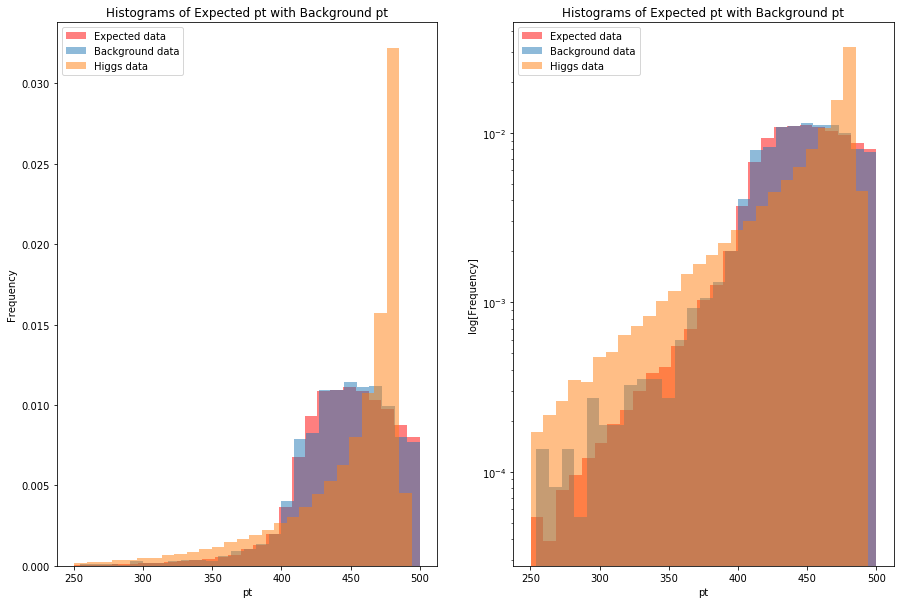

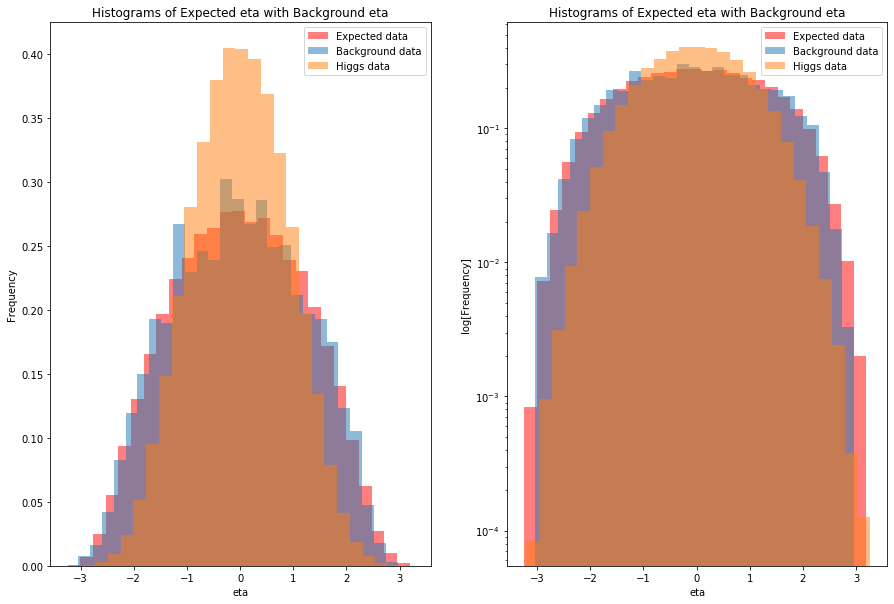

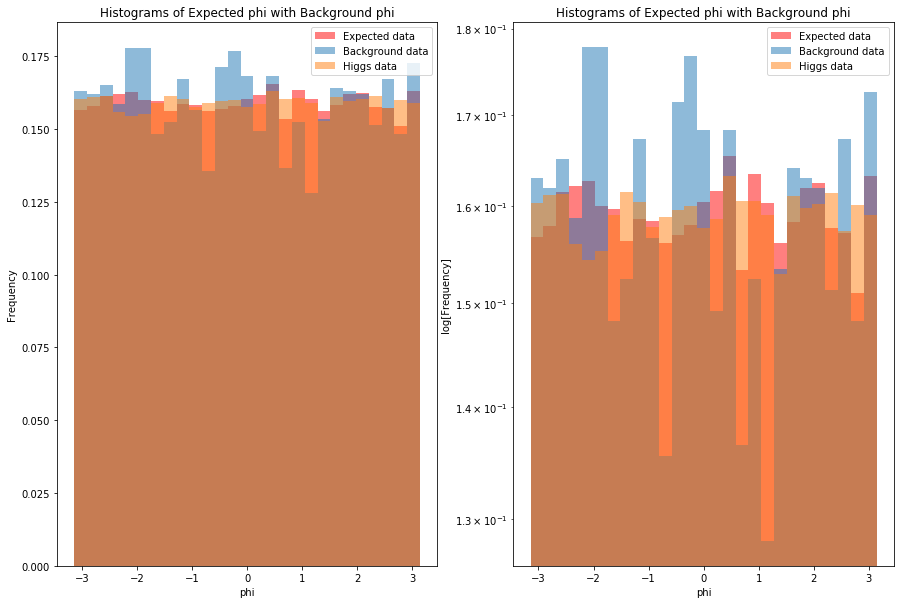

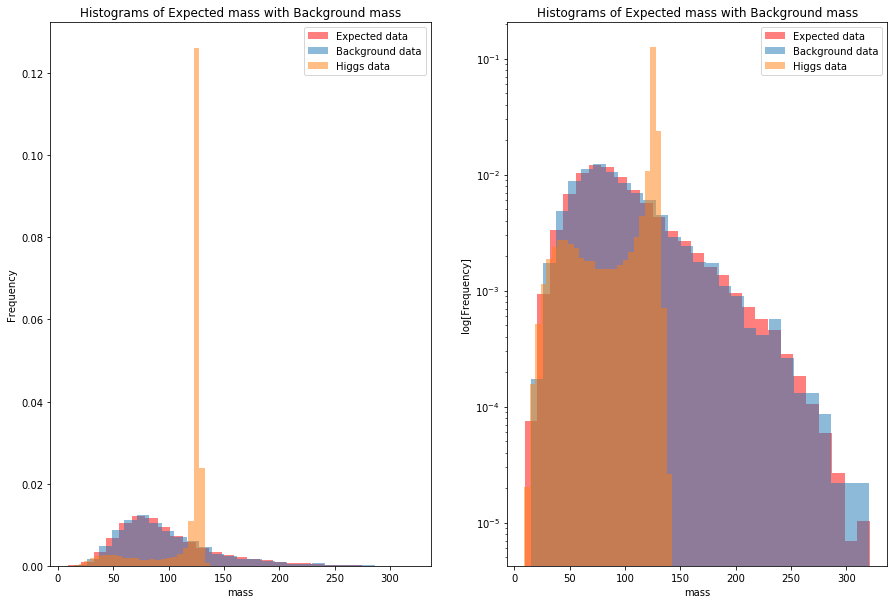

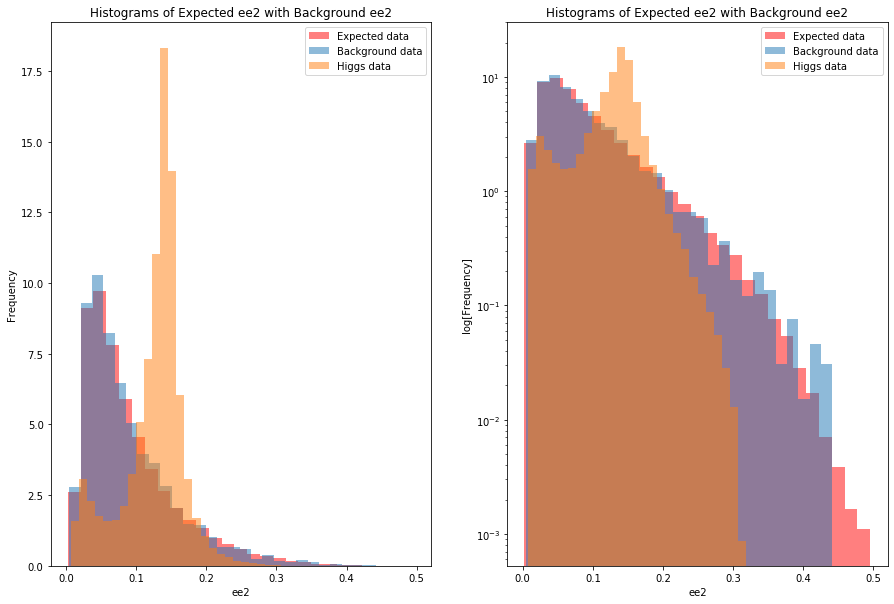

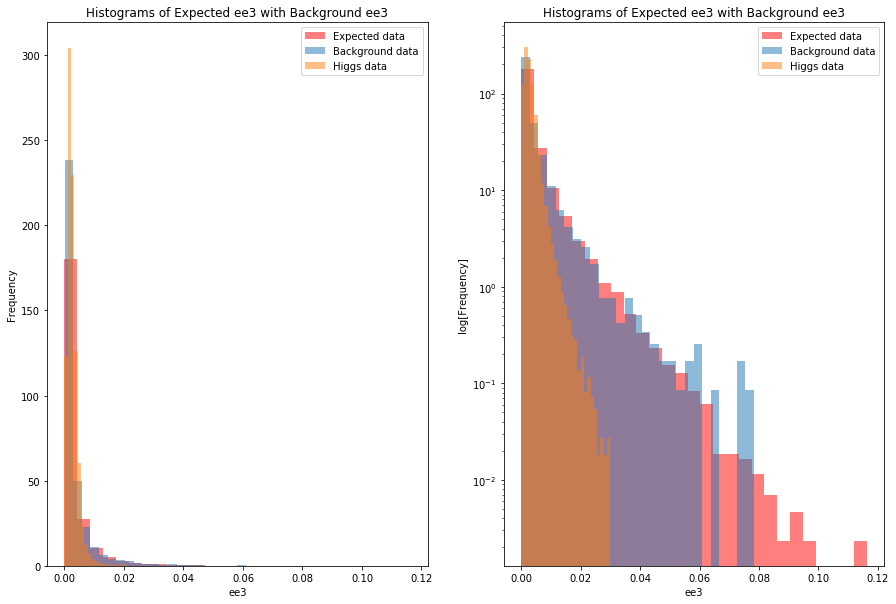

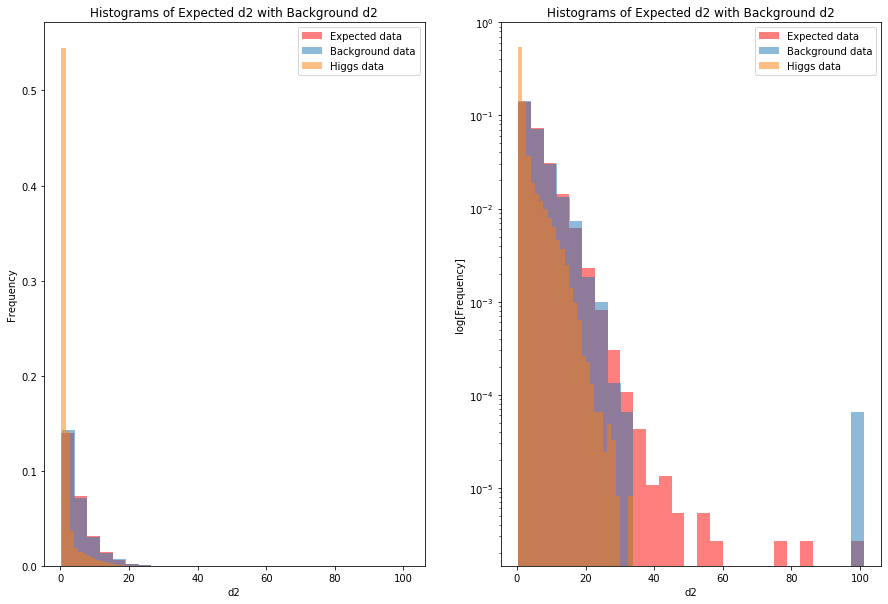

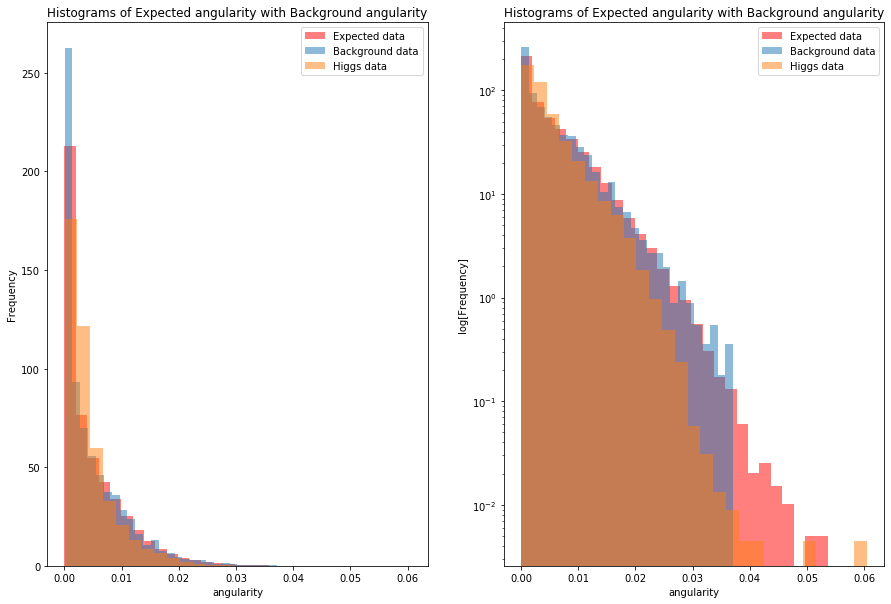

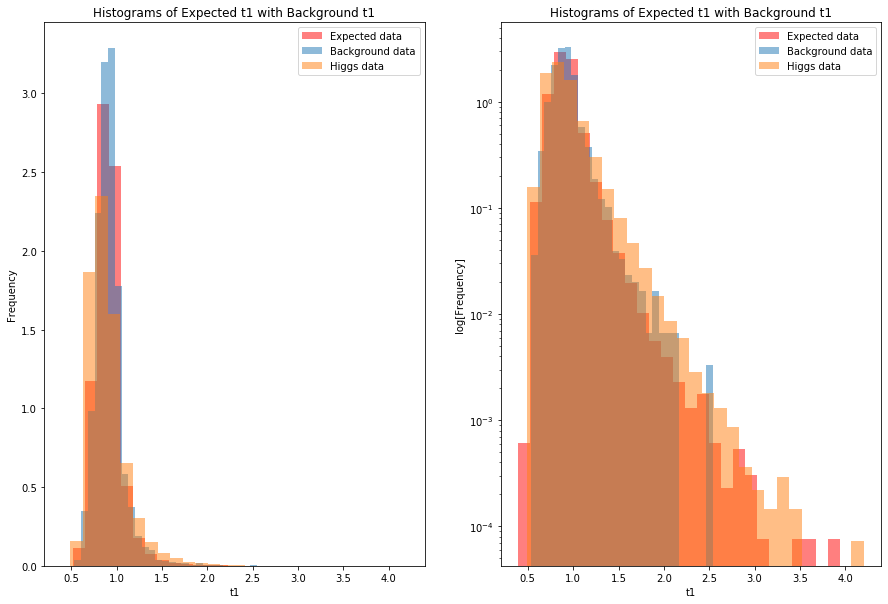

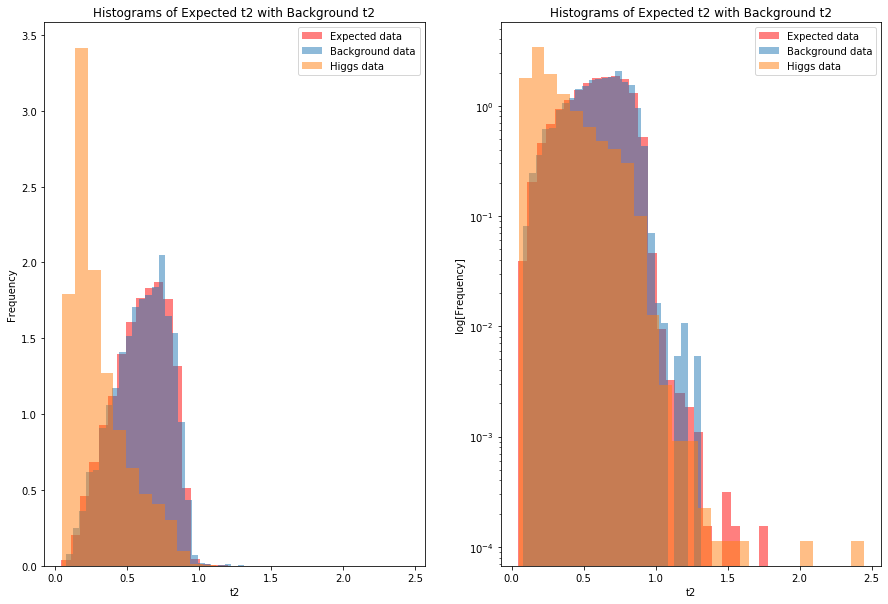

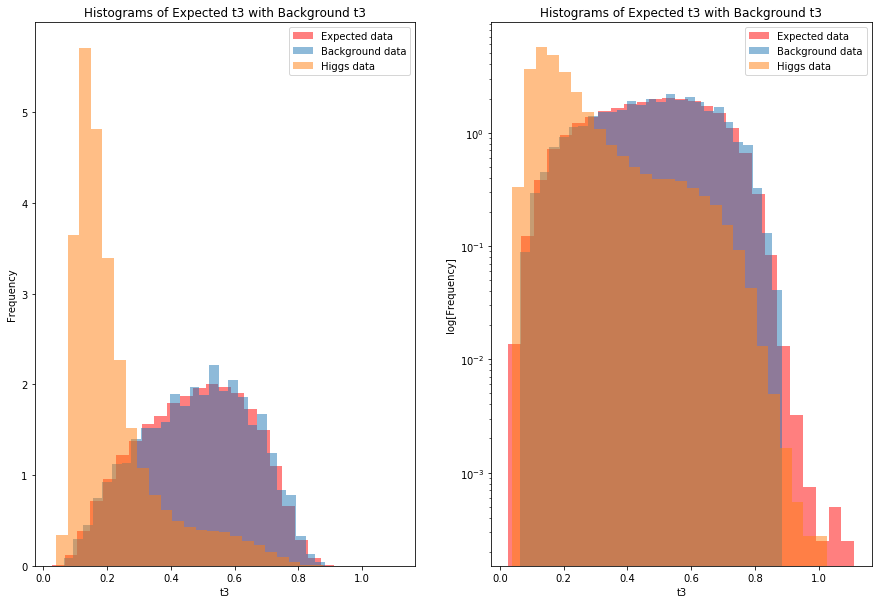

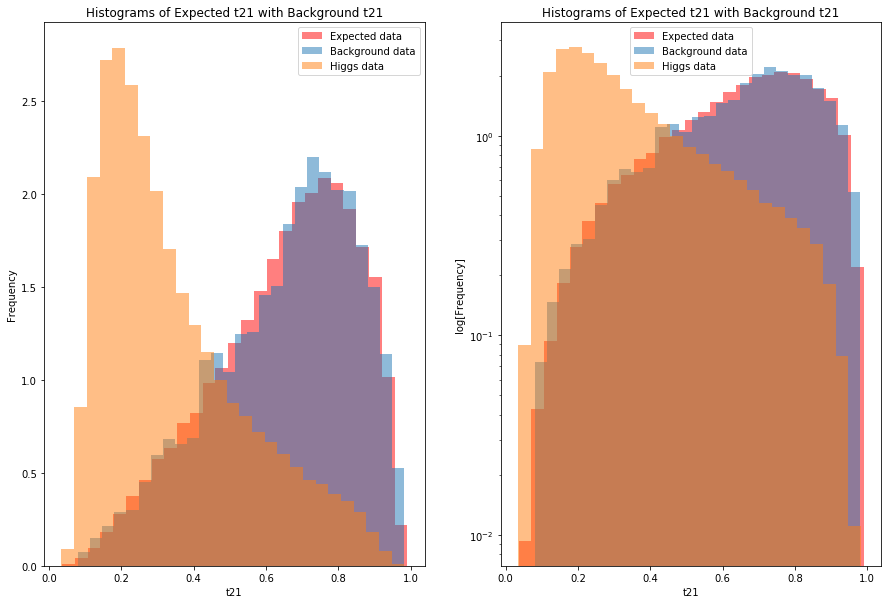

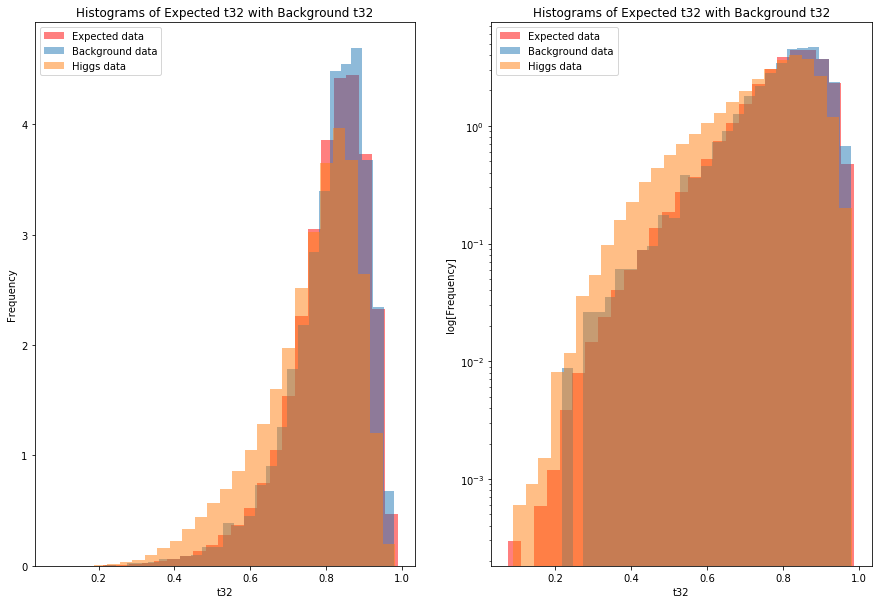

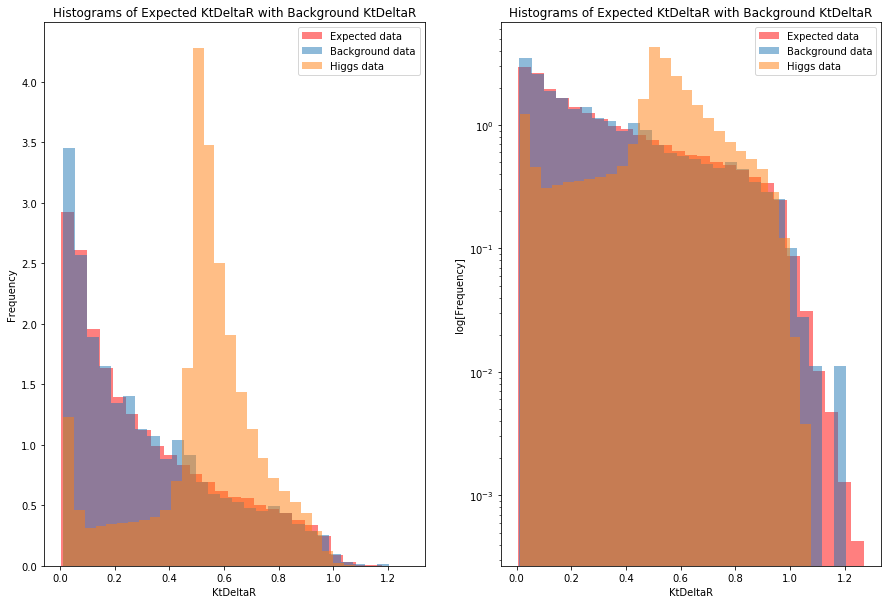

In [221]:
for var in low_lum_data.keys():
    histograms_3(qcd_data.get(var), low_lum_data.get(var), higgs_data.get(var), var, 27)
    
cut_low_lum = cut_data(low_lum_data)

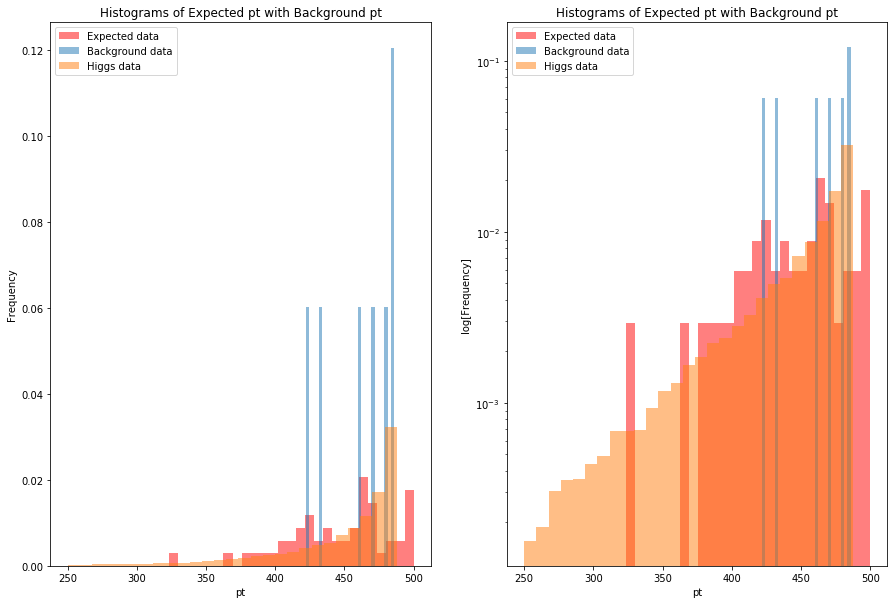

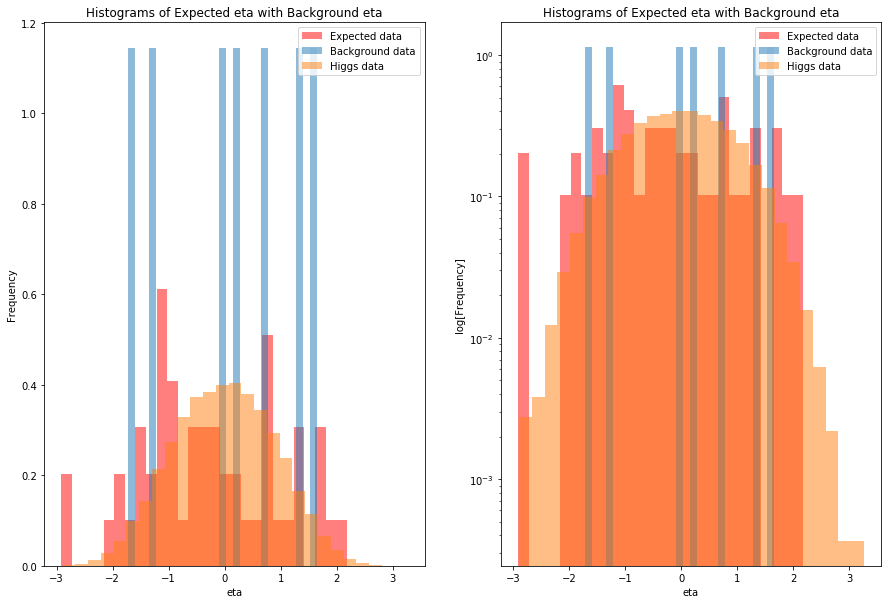

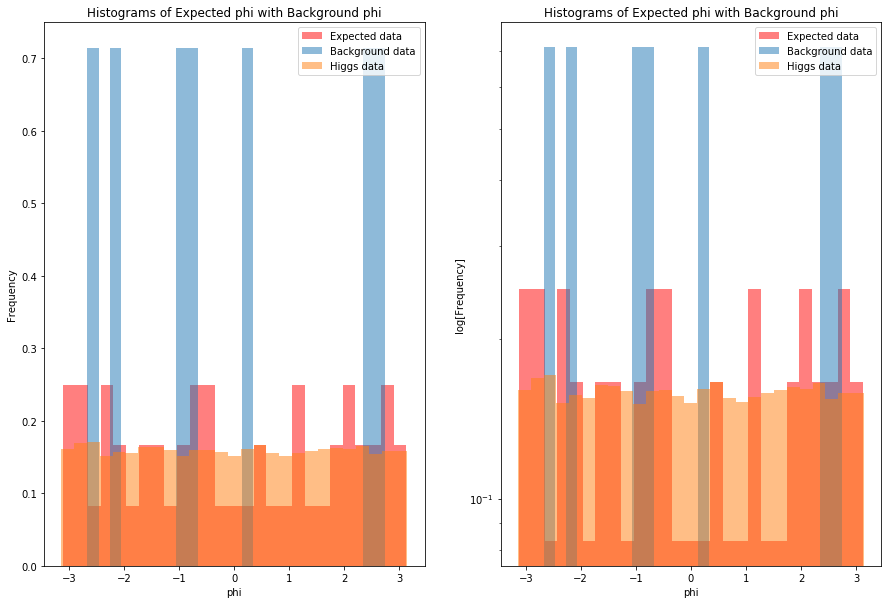

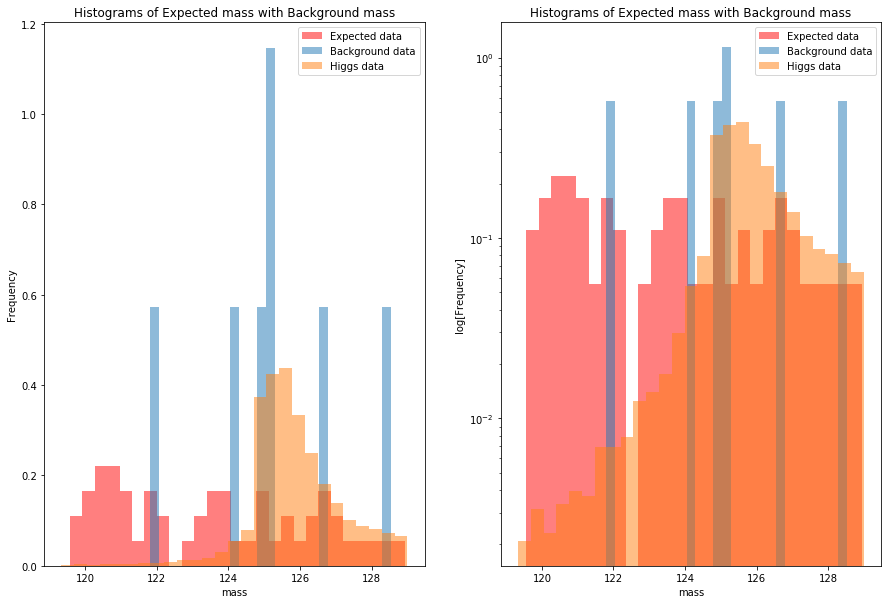

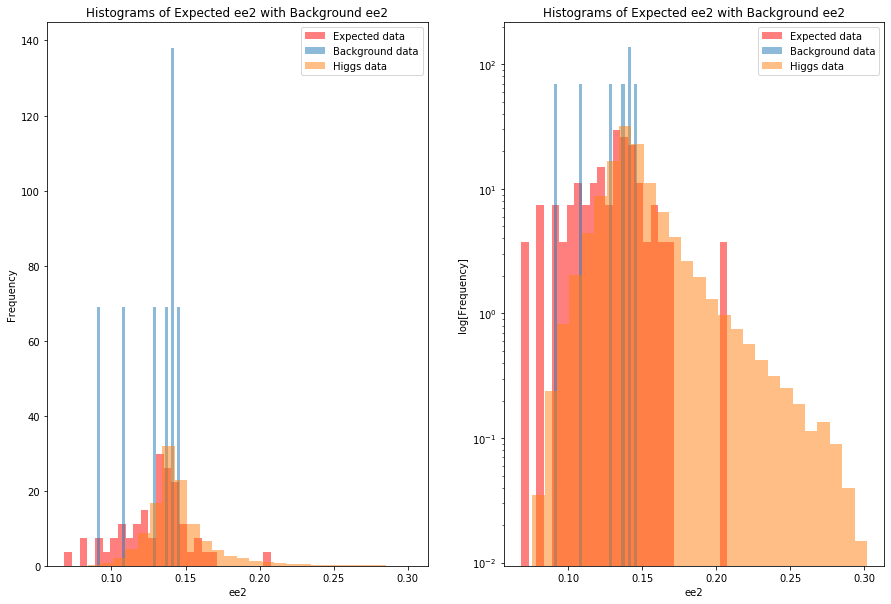

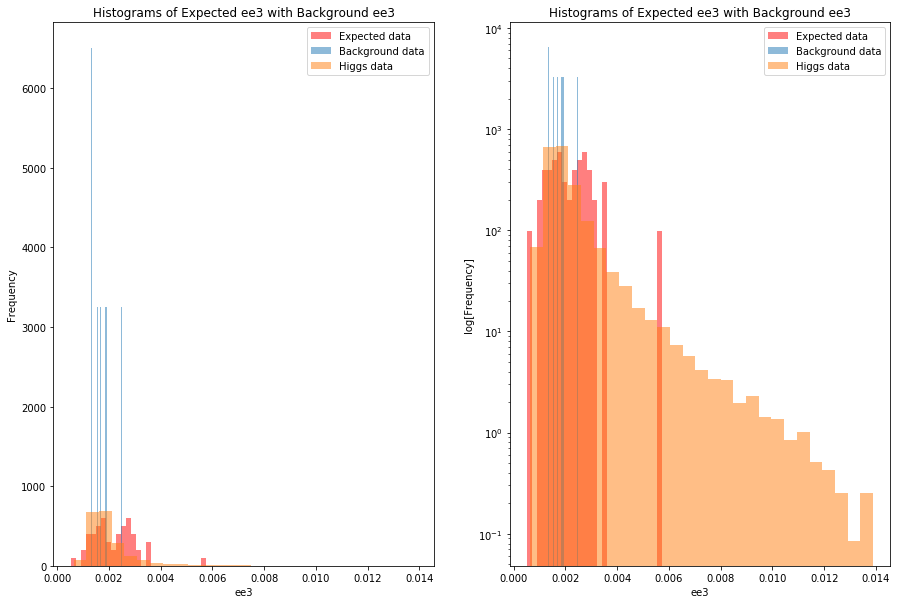

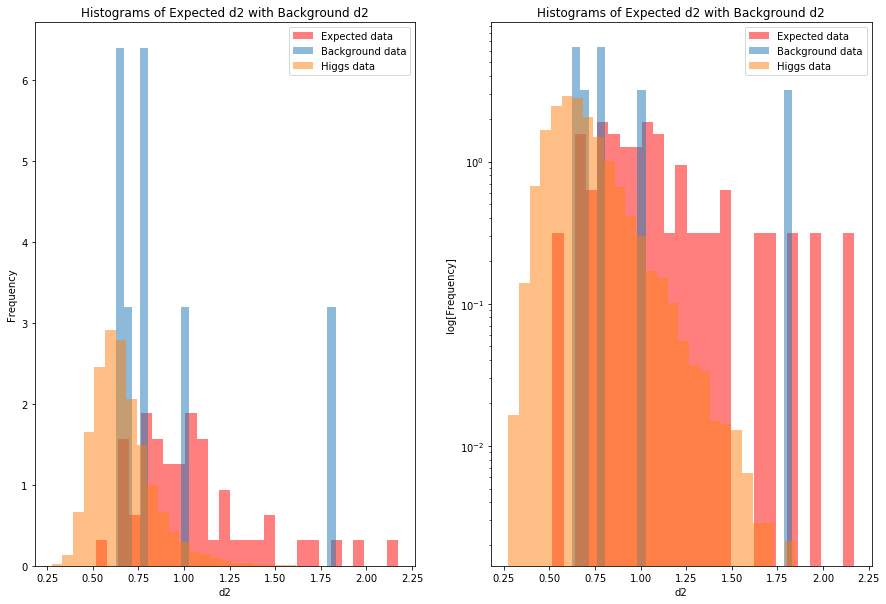

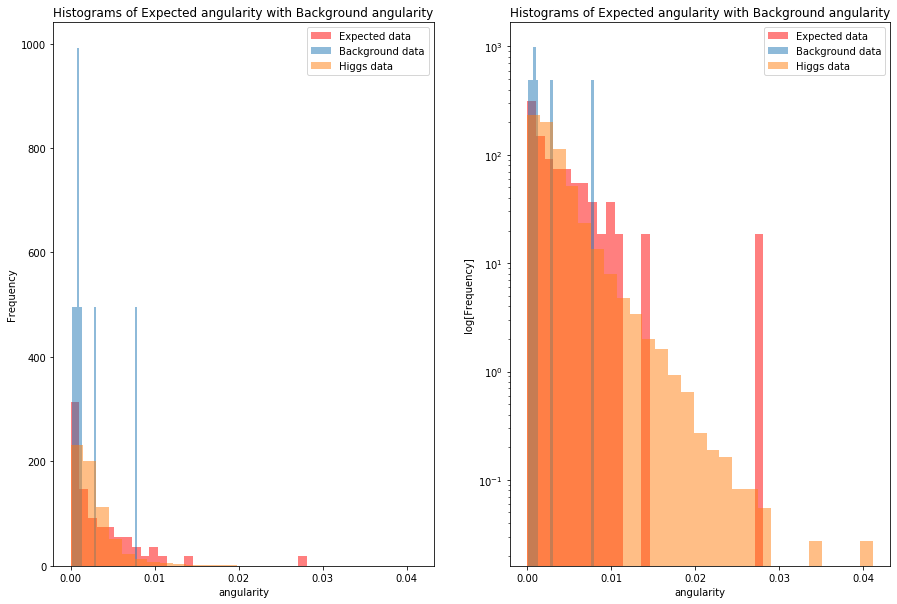

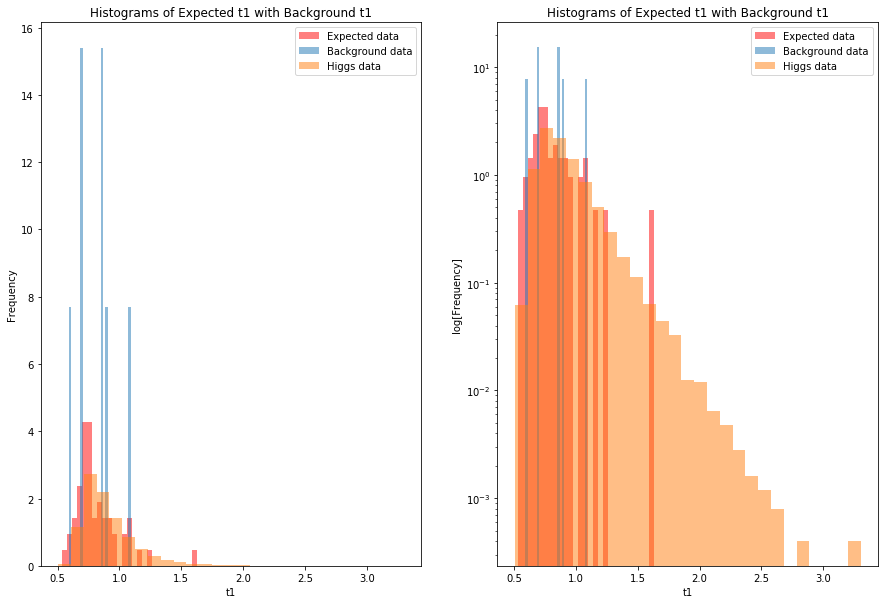

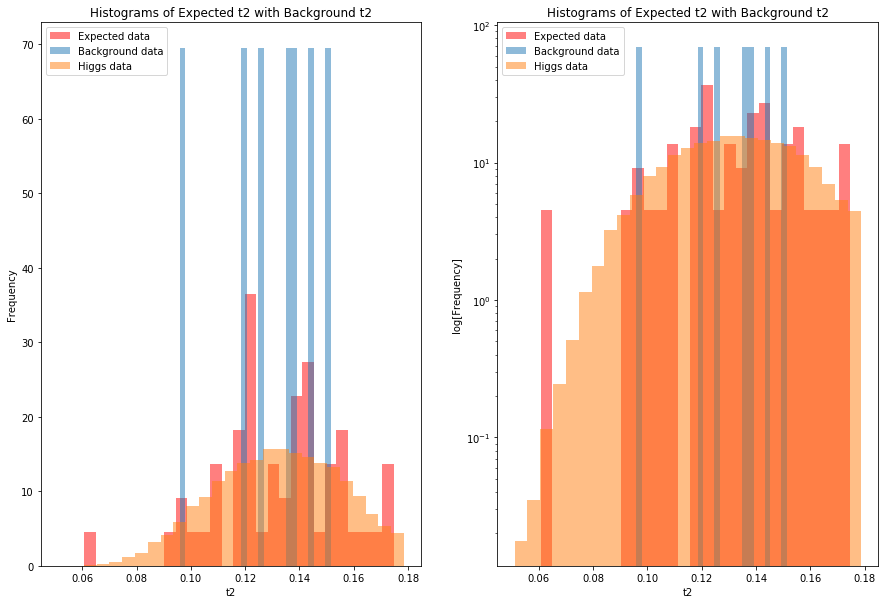

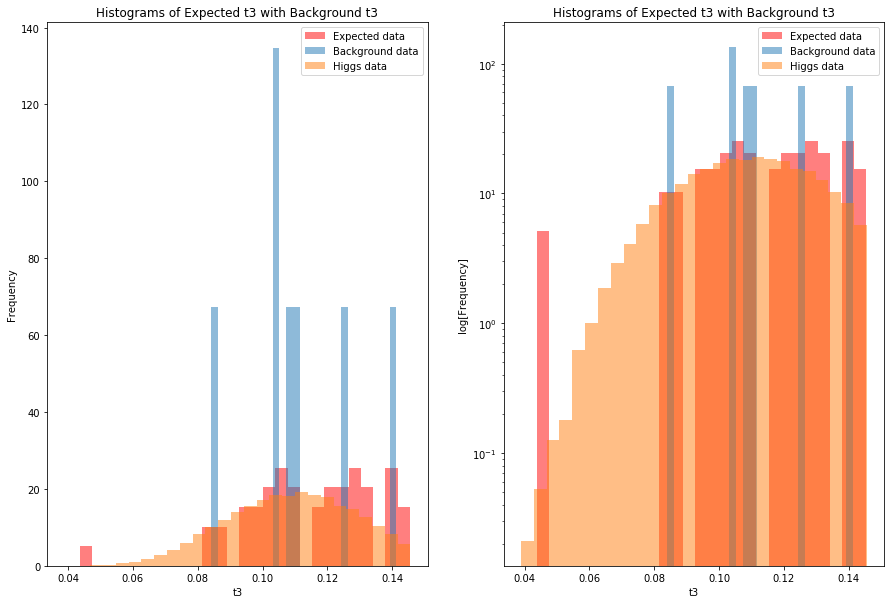

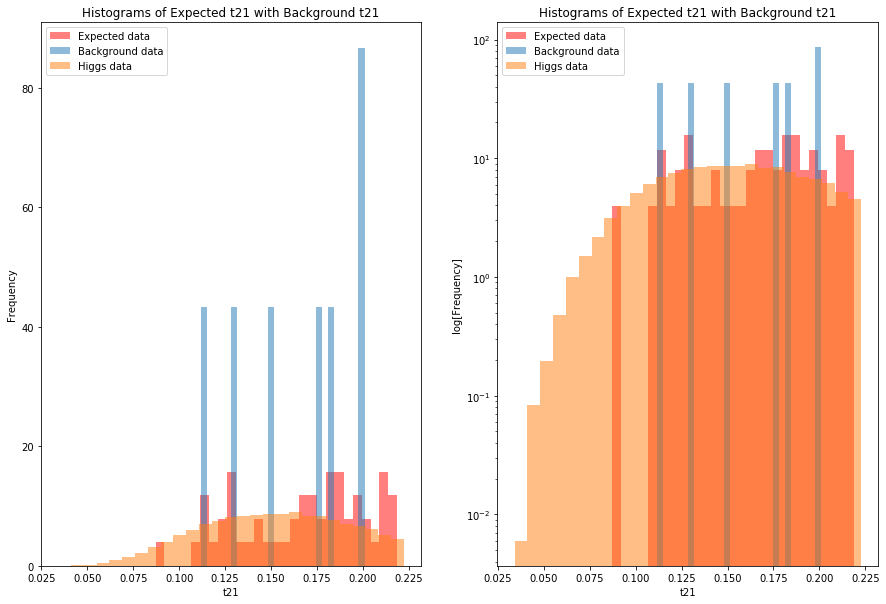

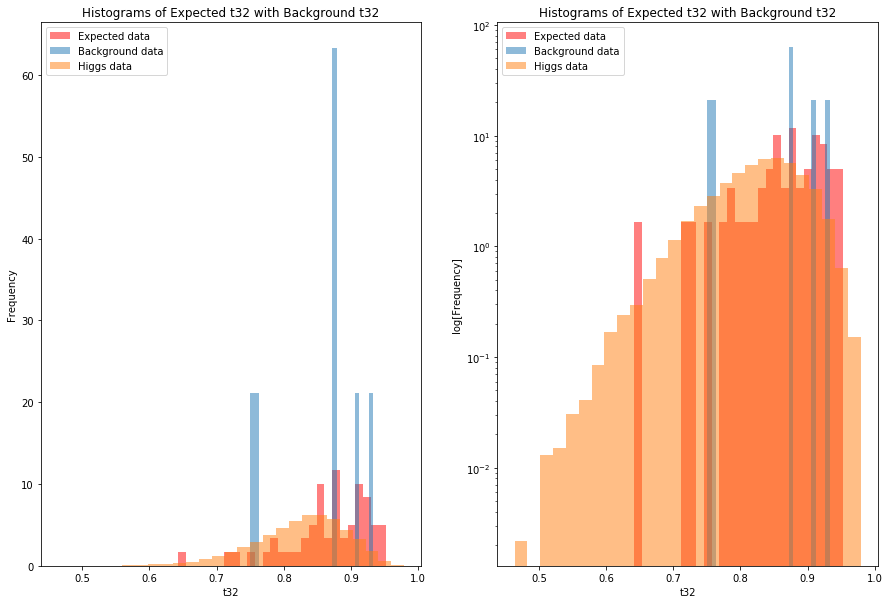

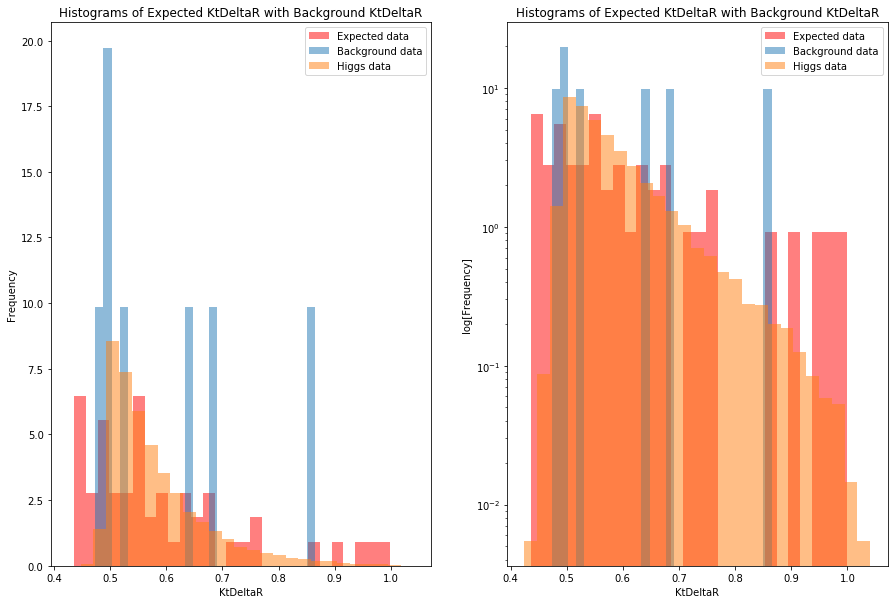

In [222]:
for var in low_lum_data.keys():
    histograms_3(final_qcd_cuts.get(var), cut_low_lum.get(var), final_higgs_cuts.get(var), var, 27)

In [226]:
print('Low Lum data size:\t',len(cut_low_lum.get('mass')))
print('QCD data size:\t\t',len(final_qcd_cuts.get('mass')) / weight_qcd)
print('Higgs data size:\t',len(final_higgs_cuts.get('mass')) / weight_higgs)

Low Lum data size:	 7
QCD data size:		 10.4
Higgs data size:	 24.099


In [227]:
scale_factor = len(low_lum_data.get('mass')) / 20000
background_counts = scale_factor * (len(final_qcd_cuts.get('mass')) / weight_qcd)
significance_data = stats.poisson.sf(len(cut_low_lum.get('mass')), mu = background_counts)
sigma_data = stats.norm.ppf(1 - significance_data)

significance_sim = stats.poisson.sf((len(final_higgs_cuts.get('mass')) / weight_higgs) + (len(final_qcd_cuts.get('mass')) / weight_qcd), mu = len(final_qcd_cuts.get('mass')) / weight_qcd)
sigma_sim = stats.norm.ppf(1 - significance_sim)
print('Low Lum significance:\t',significance_data)
print('Low Lum sigma:\t\t',np.round(sigma_data, decimals=2))
print('Sim significance:\t',significance_sim)
print('Sim sigma:\t\t',np.round(sigma_sim, decimals=2))

Low Lum significance:	 0.0015356857040060214
Low Lum sigma:		 2.96
Sim significance:	 1.6273926772775098e-09
Sim sigma:		 5.92


Our signficicance for low luminosity is much less than in our simulation.

## 95\% Confidence Level of signal yields

Because we have a Poisson distribution, the standard deviation will be the square root of the mean.

In [234]:
def confidence(num, mean, interval):
    z = stats.norm.ppf(interval)
    return z * mean / num

In [236]:
higgs_count = scale_factor * (len(final_higgs_cuts['mass']) / weight_higgs)
low_count = len(cut_low_lum['mass'])

exp_confidence = confidence(higgs_count, np.sqrt(higgs_count), 0.95)
obs_confidence = confidence(low_count, np.sqrt(low_count), 0.95)

print('expected 95% conf upper bound:\t',round(higgs_count + exp_confidence))
print('observed 95% conf upper bound:\t',round(low_count + obs_confidence))

expected 95% conf upper bound:	 6.0
observed 95% conf upper bound:	 8.0


Because the upper bound of our observed 95% confidence interval is higher than that of the expeected value, the expected value is contained within the 95% confidence interval of the observed data.